# NATRE micro vs finescale

Here I compare the NATRE microstructure estimates with my Argo finestructure estimates. Key questions:

1. How well do the two agree?
   - they don't! The argo average χ seems to miss any eddy contribution; it agrees really well with the "mean stirring" estimate of Ferrari & Polzin.
1. If I average the microstructure to 200m bins can I recover the decomposition or not?
   - TODO; skipped for now since it looks like the Argo estimate misses eddies

In [1]:
%load_ext watermark
%matplotlib inline

import glob

import cf_xarray as cfxr
import dask
import dcpy
import distributed
import matplotlib as mpl
import matplotlib.pyplot as plt
import numpy as np
import tqdm
from IPython.display import Image

import eddydiff as ed
import xarray as xr

xr.set_options(keep_attrs=True)

plt.rcParams["figure.dpi"] = 140
plt.rcParams["savefig.dpi"] = 200
plt.style.use("ggplot")

%watermark -iv

eddydiff   : 0.1
cf_xarray  : 0.5.3.dev29+g3660810.d20210729
numpy      : 1.21.1
dask       : 2021.7.2
tqdm       : 4.62.0
dcpy       : 0.1
xarray     : 0.17.1.dev3+g48378c4b1
matplotlib : 3.4.2
distributed: 2021.7.2



## Get datasets

There are 3

1. NATRE microstructure
1. NATRE finescale
1. Argo finescale

In [2]:
natre = ed.natre.read_natre().load()
bins = ed.sections.choose_bins(natre.gamma_n, depth_range=np.arange(150, 2001, 100))
natre_micro_dens = ed.sections.bin_average_vertical(
    natre.reset_coords("pres"), "neutral_density", bins
).rename({"chi": "χ", "eps": "ε", "Krho": "Kρ"})

In [3]:
natre_micro_depth = (
    natre.groupby_bins("pres", bins=np.arange(250, 2050, 200))
    .mean(...)
    .rename({"chi": "χ", "eps": "ε", "Krho": "Kρ"})
)
natre_micro_depth["pres_bins"].attrs = {
    "standard_name": "sea_water_pressure",
    "axis": "Z",
    "positive": "down",
}

In [4]:
natre_fine = xr.load_dataset("../datasets/natre-finescale.nc")
natre_fine_depth = (
    natre_fine.groupby_bins("pressure", bins=np.arange(250, 2001, 200))
    .mean()
    .cf.guess_coord_axis()
)
natre_fine_depth.pressure_bins.attrs = {
    "positive": "down",
    "standard_name": "sea_water_pressure",
}

In [7]:
argo_fine_profiles = xr.load_dataset(
    "../datasets/argomix_natre.zarr", engine="zarr"
).drop("DIRECTION")
argo_fine_profiles["Kt"] = argo_fine_profiles["Kρ"]
argo_fine_profiles["Kt"].attrs["long_name"] = "$K_T$"
# argo_fine_profiles = argo_fine_profiles.where(argo_fine_profiles.ε < 0.1)
bins = cfxr.bounds_to_vertices(natre_micro_dens.gamma_n_bounds, "bounds").data
argo_fine_dens = (
    argo_fine_profiles.rename({"γmean": "gamma_n"})
    .reset_coords("pressure")
    .groupby_bins("gamma_n", bins=bins)
    .mean()
)
argo_fine_dens["gamma_n_bins"].attrs = {
    "standard_name": "neutral_density",
    "axis": "Z",
    "positive": "down",
}
argo_fine_dens["npts"] = (
    argo_fine_profiles.χ.rename({"γmean": "gamma_n"})
    .groupby_bins("gamma_n", bins=bins)
    .count()
)
argo_fine_dens = argo_fine_dens.set_coords("pressure")

argo_fine_depth = argo_fine_profiles.groupby_bins(
    "pressure", np.arange(250, 2050, 200)
).mean()
argo_fine_depth["pressure_bins"].attrs = {"standard_name": "sea_water_pressure"}

## Finescale vs microscale

1. The finescale $⟨ε^{200}⟩$ estimates agree well with microscale $⟨ε^{0.5}⟩$
1. NATRE finescale $⟨K_ρ^{200}⟩$ agrees with Argo finescale $⟨K_ρ^{200}⟩$ **which agrees with $K_ρ^m$** $= Γ⟨ε^{0.5}⟩/N_m^2$ i.e. a diapycnal diffusivity for the stirring of the large scale vertical gradient by the microscale. Somehow calculating a 200-m diffusivity using the finestructure $ε^{200}$ and 200-m scale $N²$ seems to average us out to the "large scale"
1. Argo finescale $⟨χ^{200}⟩ = ⟨Γε^{200}/N\_{200}^2 ; ∂_zT\_{200}^2⟩$ seems to miss the whole eddy contribution to variance production! This is robust to averaging in γ or P, so it is not a question of the bins being too fine for the 200m mean χ estimate in each profile. I think the issue is scaling the 200-m $ε^{200}$ with 200-m scale gradients to get $χ^{200}$
1. NATRE microscale $⟨K_ρ⟩$  and $⟨K_T⟩$ is quite different near the top.
1. The large-scale mean $K_T^m$ is the (meaningless) diffusivity required to explain $⟨χ⟩$ by microscale stirring on the mean vertical gradient. that's why there's a peak where variance is actually being generated by mesoscale stirring of the lateral gradient.

TODO:

1. The disagreement between microscale $⟨K_ρ⟩$ and the $K_ρ^m$ or finescale $K_ρ$ is the key I think. I think the 200-m averaging inherent in the finescale estimate is filtering out the mesoscale. BUT then the 200m averaged microscale $⟨K_ρ⟩$ should also reflect this? But maybe I should calculate the 200m scale diffusivity instead of averaging the 0.5m scale diffusivity in 200m bins.
1. Is there any way I can estimate the **microscale** $K_ρ$ that gets me back to the "large-scale" $K_ρ^m$
1. Look at individual profiles of $χ, ε, χ^{200}, ε^{200}$; is the 200-m average taking out the eddy stirring contribution to $T_z$? Since they are compensated it makes sense that $N² ≪ gαT_z^2$ at scales smaller than horizontal stirring vertical scale

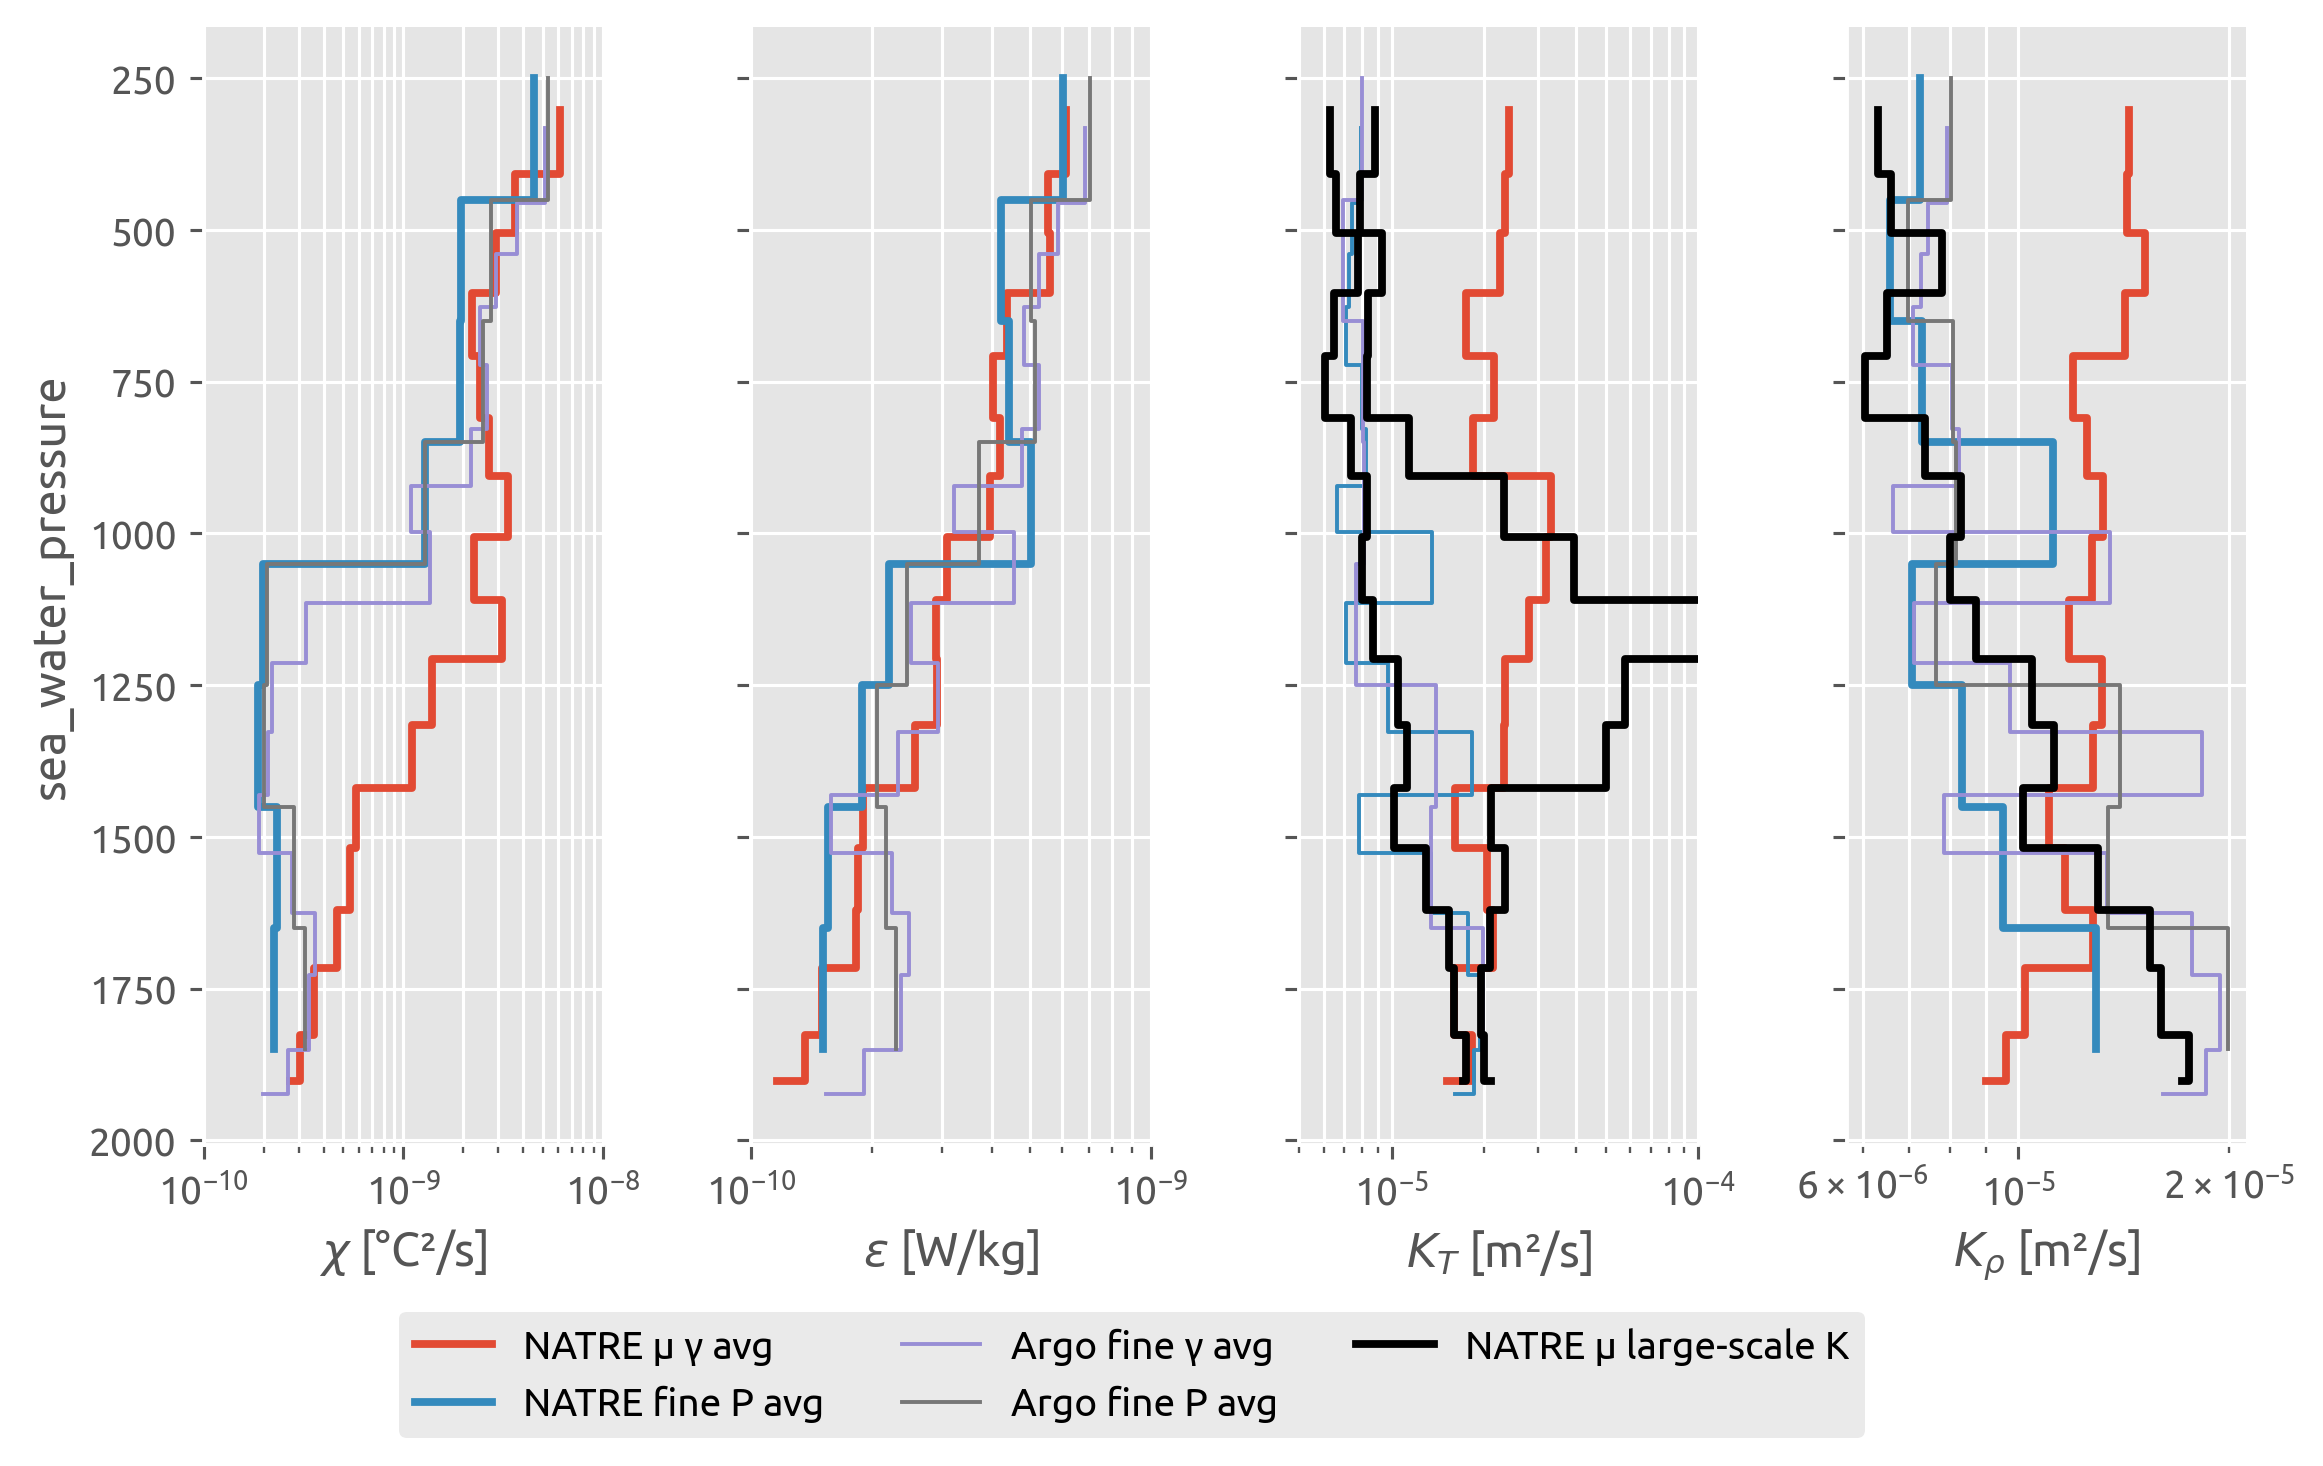

In [138]:
f, axx = plt.subplots(1, 4, sharey=True)
ax = dict(zip(["χ", "ε", "Kt", "Kρ"], axx))

hdl = []
for var, axis in ax.items():
    for ds, lw in zip(
        [
            natre_micro_dens,
            natre_fine_depth.sel(criteria="kunze"),
            # natre_micro_depth,
            argo_fine_dens,
            argo_fine_depth,
        ],
        [2, 2, 1, 1],
    ):
        if var in ds:
            h = ds[var].cf.plot.step(
                y="sea_water_pressure", xscale="log", ax=axis, lw=lw
            )
            if var == "Kρ":
                hdl.append(h[0])


natre_micro_dens["Kt_m"].cf.plot.step(
    y="sea_water_pressure", xscale="log", ax=ax["Kt"], lw=2, color="k", _labels=False
)
h = natre_micro_dens["Krho_m"].cf.plot.step(
    y="sea_water_pressure", xscale="log", ax=ax["Kt"], lw=2, color="k", _labels=False
)
h = natre_micro_dens["Krho_m"].cf.plot.step(
    y="sea_water_pressure", xscale="log", ax=ax["Kρ"], lw=2, color="k", _labels=False
)
hdl.append(h[0])

f.legend(
    hdl,
    [
        "NATRE μ γ avg",
        # "NATRE μ P avg",
        "NATRE fine P avg",
        "Argo fine γ avg",
        "Argo fine P avg",
        "NATRE μ large-scale K",
    ],
    ncol=3,
    loc="center",
    bbox_to_anchor=(0.5, 0),
)

ax["χ"].set_xlim([1e-10, 1e-8])
ax["ε"].set_xlim([1e-10, 1e-9])
ax["Kt"].set_xlim([5e-6, 1e-4])

[aa.grid(True, which="minor", axis="x") for aa in axx]
ax["Kt"].set_title("")
dcpy.plots.clean_axes(axx)
plt.tight_layout(h_pad=0.1, w_pad=0.1)

plt.gcf().set_size_inches((9, 5))

## Studying N² vs $T_z, S_z$

Well this is pretty clear!

There are compensated vertical gradients of $T_z$ and $S_z$ of ≈ 10-30m scale. So a 200-m diffusivity is acting on the much larger scale gradient $∂_z θ_m$ *not* $∂_z(θ_m + θ_e)$, the latter being the mean for the microscale diffusivity.

Another interesting thing is that $⟨K_ρ^μ⟩ = K_ρ^m$ i.e. "large-scale" average $K_ρ$ _is_ the diffusivity for the "large-scale" because there is no stirring of density!

The other way to think of it is that $K_T ≠ K_ρ$ at scales of spiciness i.e. compensated T-S variability.

In [8]:
natre["NT2"] = 9.81 * dcpy.eos.alpha(natre.salt, natre.temp, natre.pres) * natre.Tz
natre["NS2"] = (
    9.81
    * dcpy.eos.beta(natre.salt, natre.temp, natre.pres)
    * natre.salt.interpolate_na("depth").differentiate("depth")
)

In [93]:
profile = natre.isel(latitude=3, longitude=6).temp.interpolate_na("depth")
dcpy.ts.PlotSpectrum(profile)
dcpy.ts.PlotSpectrum(profile.rolling(depth=7, center=True).mean(), ax=plt.gca())
dcpy.ts.PlotSpectrum(profile.rolling(depth=31, center=True).mean(), ax=plt.gca())

Canvas(toolbar=Toolbar(toolitems=[('Home', 'Reset original view', 'home', 'home'), ('Back', 'Back to previous …

0.4000000000000341
0.4000000000000341
0.4000000000000341


([<matplotlib.lines.Line2D at 0x7fc910df1910>],
 <AxesSubplot:title={'center':' Sea water temperature\n[degrees_Celsius]'}, xlabel='Wavelength/2π', ylabel='PSD'>)

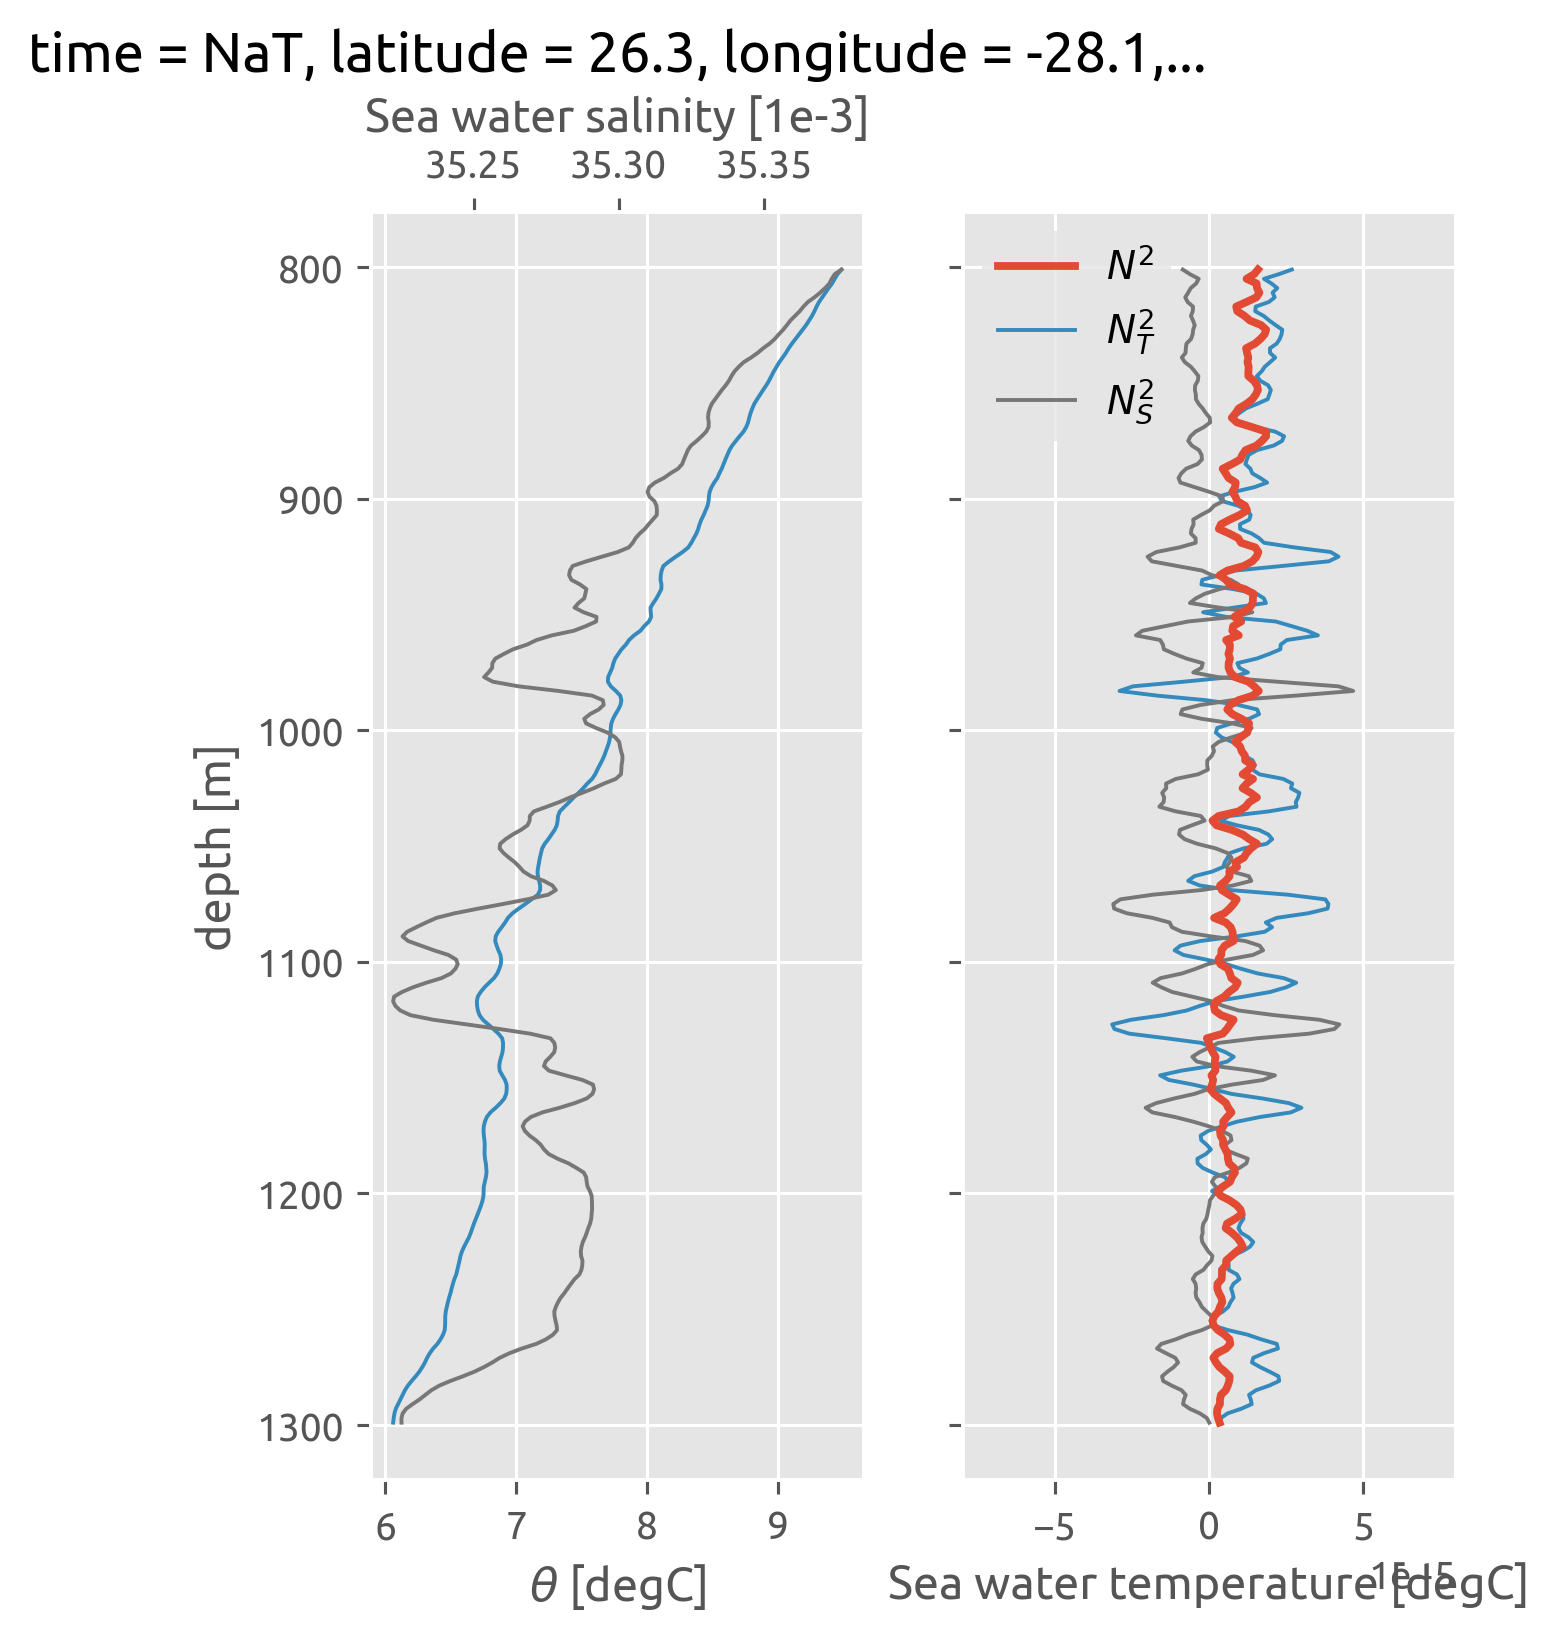

In [104]:
%matplotlib inline
plt.rcParams["figure.dpi"] = 140

profile = (
    natre.isel(latitude=3, longitude=6)
    .rolling(depth=21, center=True, min_periods=1)
    .mean()
    .coarsen(depth=5, boundary="trim")
    .mean()
    .sel(depth=slice(800, 1300))
)

profile["NT2"] = (
    -9.81
    * dcpy.eos.alpha(profile.salt, profile.temp, profile.pres)
    * profile.theta.interpolate_na("depth").differentiate("depth")
)
profile["NS2"] = (
    9.81
    * dcpy.eos.beta(profile.salt, profile.temp, profile.pres)
    * profile.salt.interpolate_na("depth").differentiate("depth")
)

f, ax = plt.subplots(1, 2, sharey=True)

profile.theta.cf.plot(ax=ax[0], color="C1")

axS = ax[0].twiny()
axS.grid(False)
profile.salt.cf.plot(color="C3", ax=axS)

# ax2 = ax[0].twiny()
# profile.gamma_n.cf.plot(color="k", ax=ax2)
# ax2.grid(False)

profile.N2.cf.plot(lw=2, zorder=5, ax=ax[1])
profile.NT2.cf.plot(ax=ax[1])
profile.NS2.cf.plot(color="C3", ax=ax[1])
ax[1].set_xlim([-8e-5, 8e-5])
ax[1].legend(["$N^2$", "$N_T^2$", "$N_S^2$"])

dcpy.plots.clean_axes(ax)
[aa.set_title("") for aa in ax]

f.set_size_inches((5, 6))

## Studying $K_T$ vs $K_ρ$

I'm wondering if the $K_T = K_ρ$ assumption really breaks down at the 200-m scale?

- calculate $K_T, K_ρ$ from the microstructure data at various averaging scales.

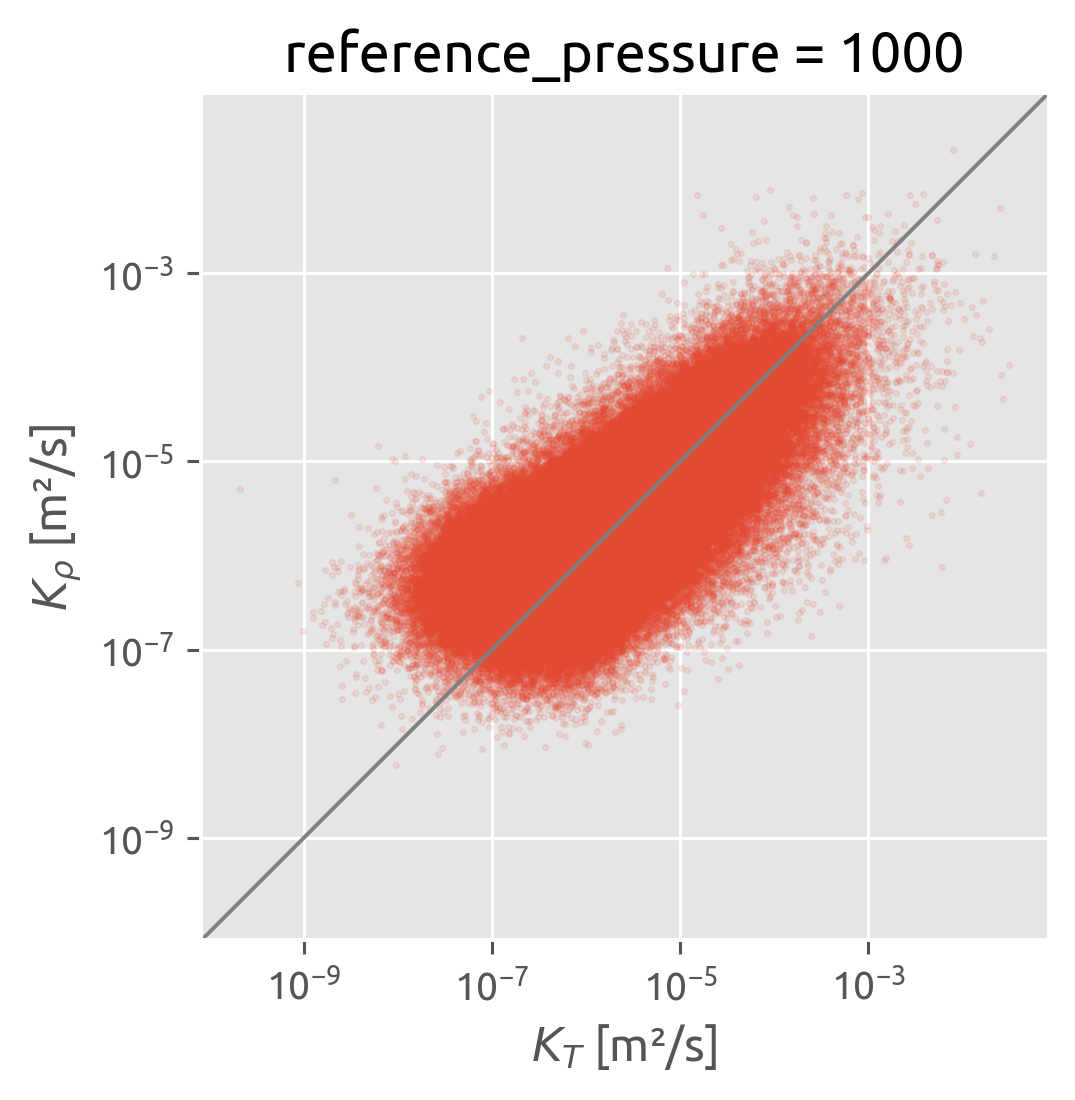

In [129]:
natre.plot.scatter(x="Kt", y="Krho", s=2, alpha=0.1)
plt.gca().set_xscale("log")
plt.gca().set_yscale("log")
dcpy.plots.line45()

## Old stuff

In [27]:
def decode_bounds_to_intervals(dataset, bounds_dim="bounds"):

    dataset = dataset.copy(deep=True)
    all_bounds = dataset.cf.bounds
    for name in set(dataset.variables) & set(all_bounds):
        bounds_name = all_bounds[name][0]
        vertices = cfxr.bounds_to_vertices(dataset[bounds_name], bounds_dim)
        intervals = ed.intervals_from_vertex(vertices)
        dataset[name] = dataset[name].copy(data=intervals)
        del dataset[name].attrs["bounds"]
        dataset = dataset.drop(bounds_name)
    return dataset


micro = decode_bounds_to_intervals(micro)

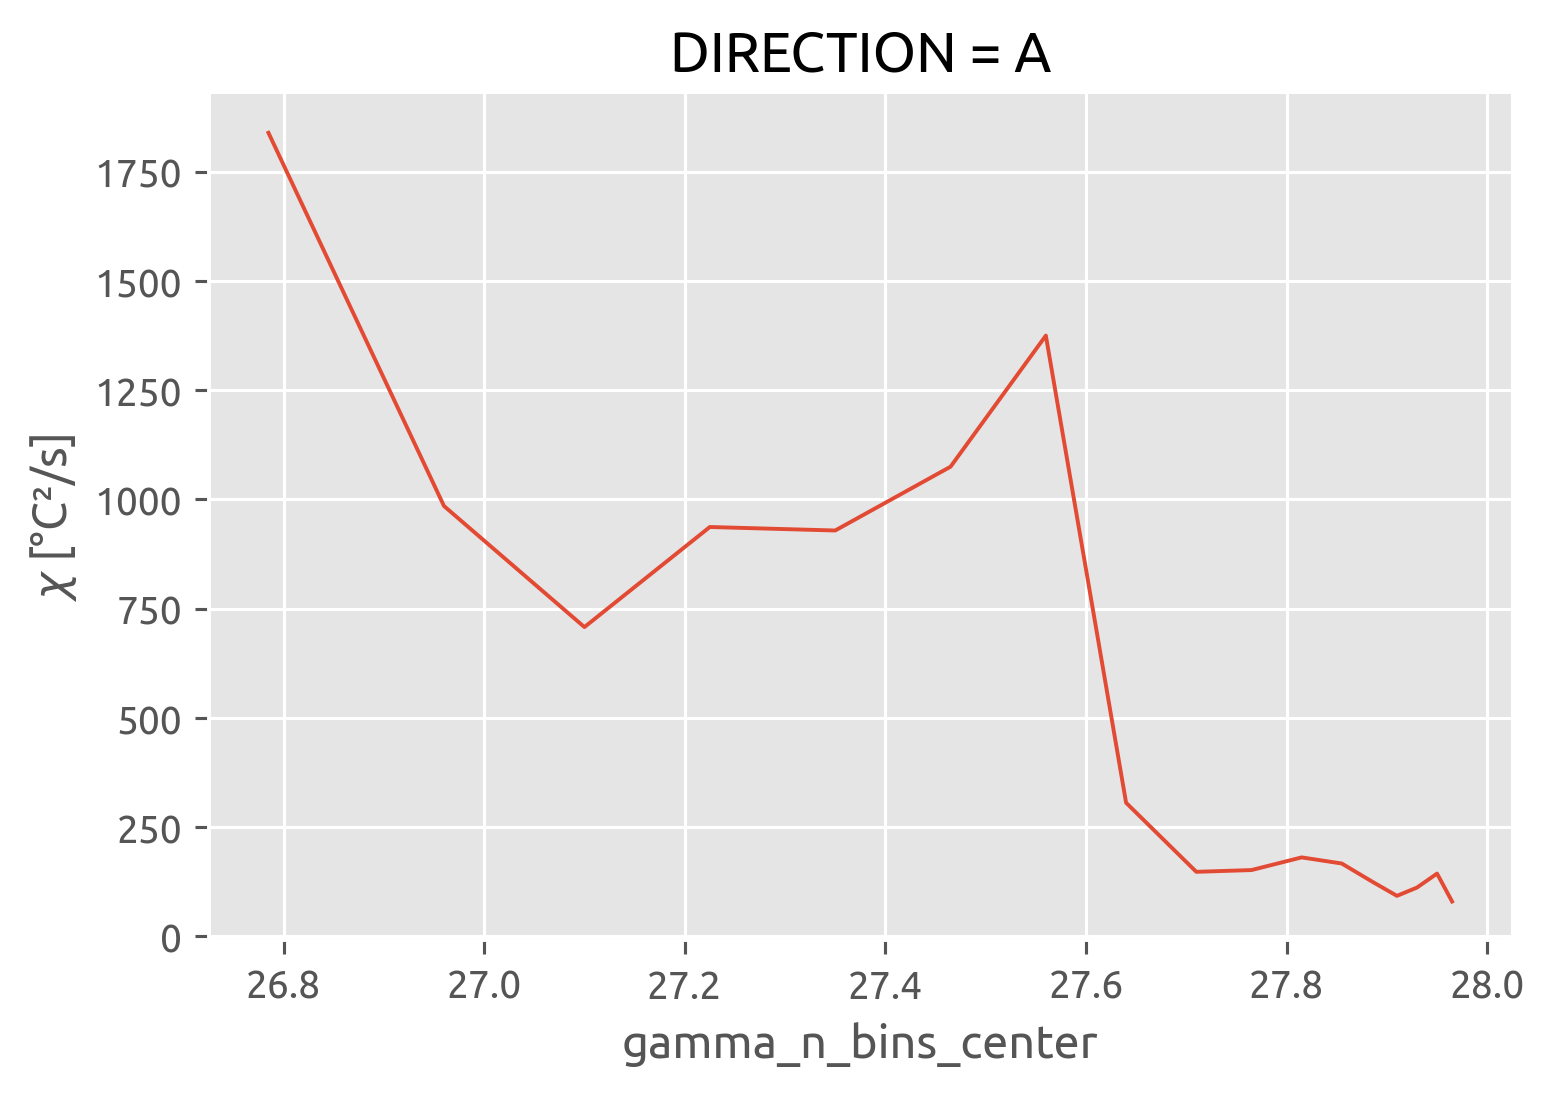

In [29]:
argo_fine.npts.plot()

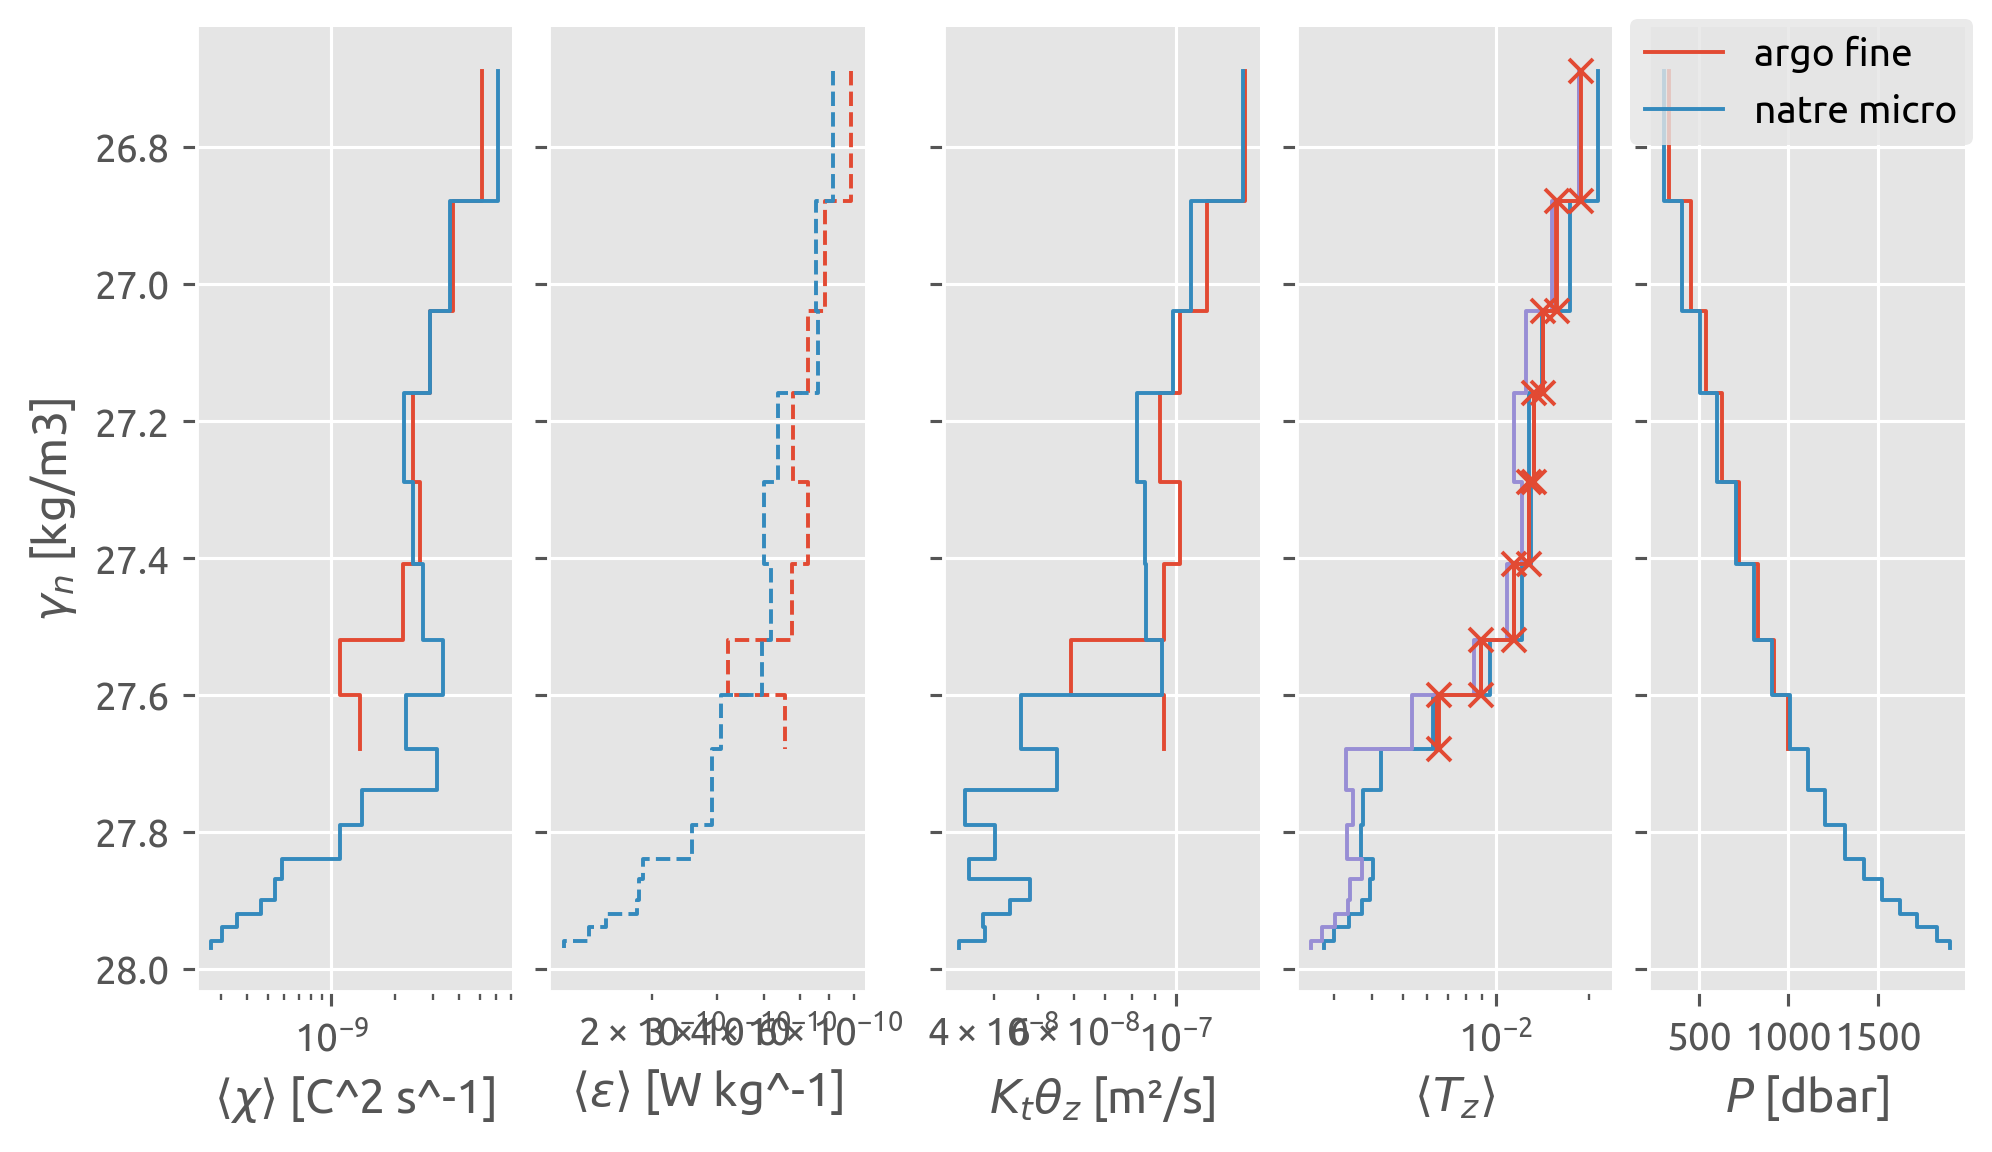

In [38]:
f, ax = plt.subplots(1, 5, sharey=True, constrained_layout=True)
kwargs = dict(y="neutral_density", xscale="log")

argo_fine.gamma_n_bins.attrs["standard_name"] = "neutral_density"
masked_argo_fine = argo_fine.where(argo_fine.npts > 300)
for var in argo_fine.variables:
    masked_argo_fine[var].attrs = argo_fine[var].attrs

masked_argo_fine.χ.cf.plot.step(ax=ax[0], **kwargs)
micro.chi.cf.plot.step(ax=ax[0], **kwargs)

masked_argo_fine.ε.cf.plot.step(ax=ax[1], color="C0", ls="--", **kwargs)
micro.eps.cf.plot.step(ax=ax[1], color="C1", ls="--", **kwargs)

masked_argo_fine.KtTz.cf.plot.step(ax=ax[2], **kwargs)
micro.KtTz.cf.plot.step(ax=ax[2], **kwargs)
# micro.KrhoTz.cf.plot.step(ax=ax[2], **kwargs)

masked_argo_fine.Tzmean.cf.plot.step(ax=ax[3], **kwargs)
micro.Tz.cf.plot.step(ax=ax[3], **kwargs)
micro.dTdz_m.cf.plot.step(ax=ax[3], **kwargs)
masked_argo_fine.mean_dTdz_seg.cf.plot.step(ax=ax[3], color="C0", marker="x", **kwargs)

masked_argo_fine.pressure.cf.plot.step(ax=ax[4], y="neutral_density")
micro.pres.cf.plot.step(ax=ax[4], y="neutral_density")

ax[-1].set_xlabel("$P$ [dbar]")
f.legend(["argo fine", "natre micro"])
dcpy.plots.clean_axes(ax)
[aa.set_title("") for aa in ax]
f.set_size_inches((7, 4))

### T-S

Hmm.. the T-S diagram for Argo profiles with which we can calculate finescale estimates should tell us if it samples any eddy stirring at all.

In [ ]:
argo_fine_full_profiles = xr.load_dataset("argo_profiles_used_for_finestructure.nc")

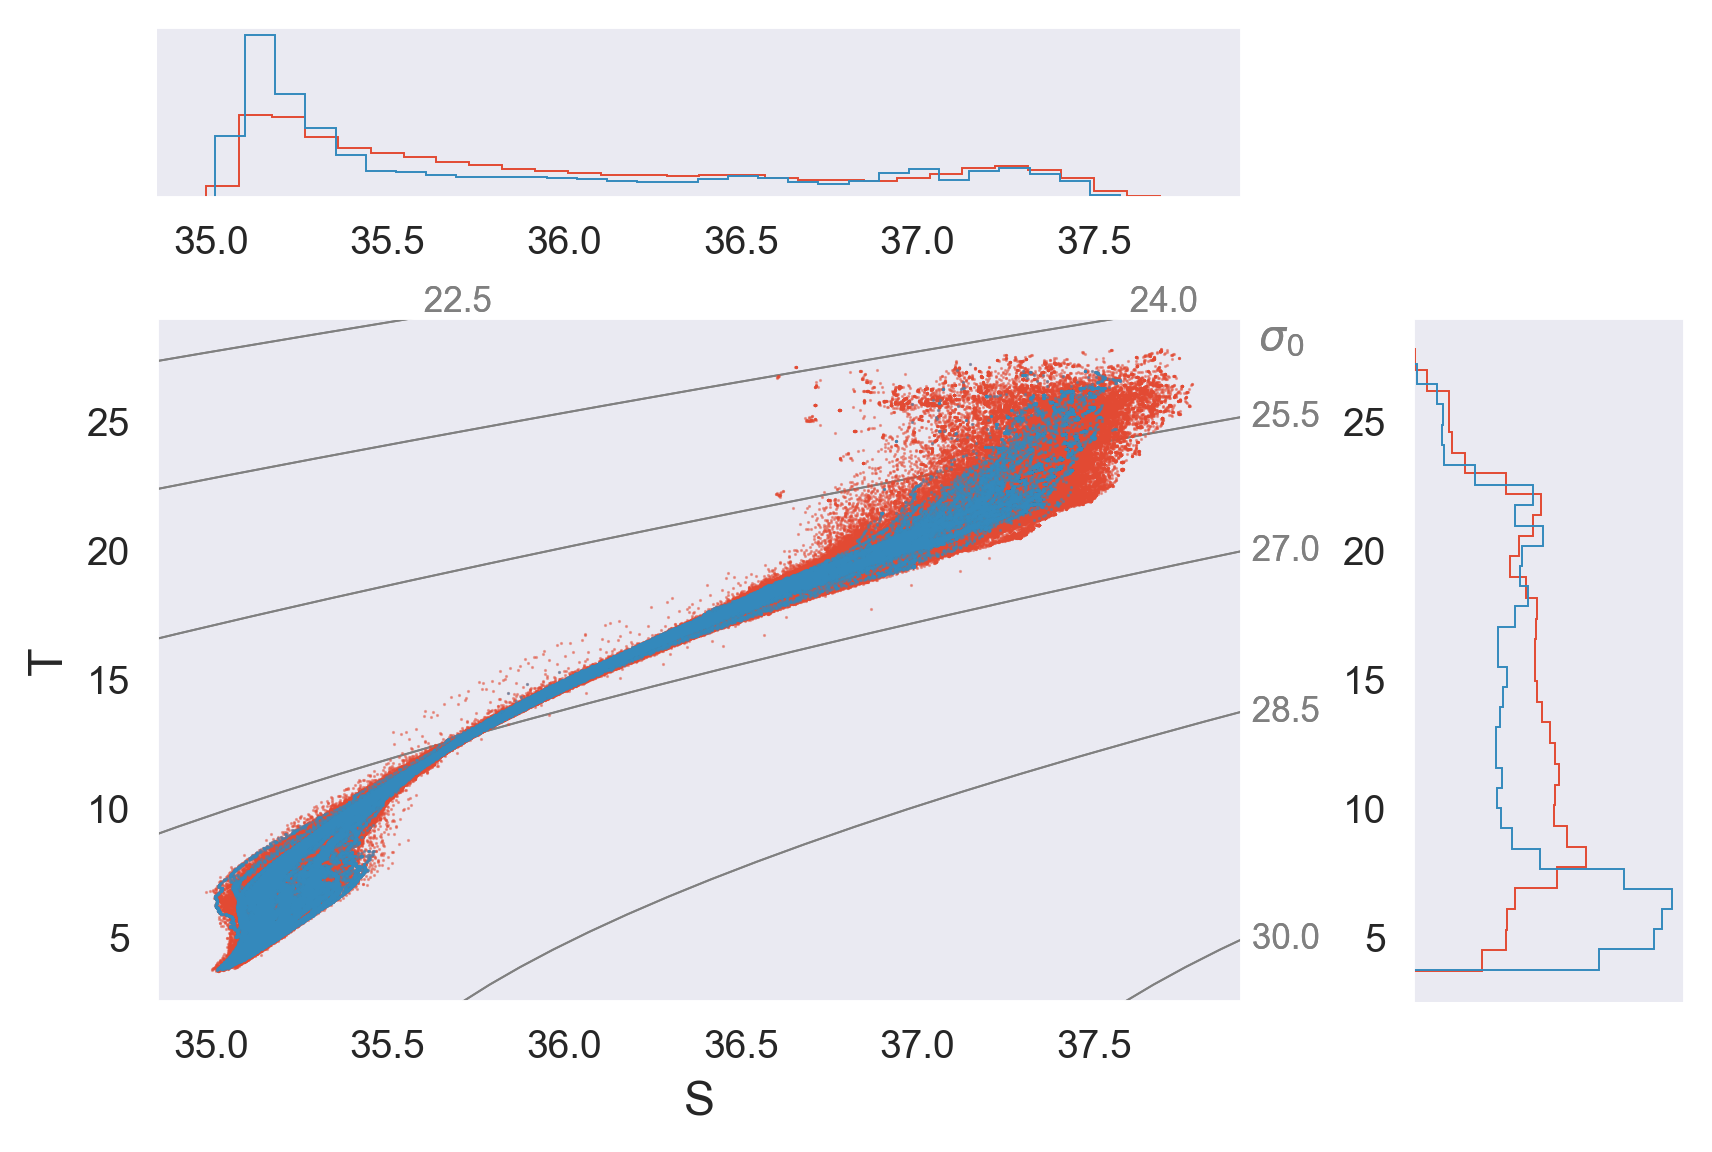

In [226]:
mask = argo_fine_full_profiles.fine_deepest_bin > 1200

kwargs = dict(hexbin=False, size=0.1)

_, ax = dcpy.oceans.TSplot(
    argo_fine_full_profiles.PSAL,
    argo_fine_full_profiles.THETA,
    **kwargs,
)
dcpy.oceans.TSplot(
    argo_fine_full_profiles.where(mask, drop=True).PSAL,
    argo_fine_full_profiles.where(mask, drop=True).THETA,
    **kwargs,
    ax=ax,
);

## Extract Argo profiles used for finescale estimates

In [139]:
import argopy

argo_profiles = argo_natre.argo.point2profile()

In [142]:
argo_profiles

<xarray.Dataset>
Dimensions:                (N_PROF: 4386, N_LEVELS: 1012)
Coordinates:
  * N_PROF                 (N_PROF) int64 26 46 2 27 47 ... 3983 471 3677 3975
  * N_LEVELS               (N_LEVELS) int64 0 1 2 3 4 ... 1008 1009 1010 1011
    LATITUDE               (N_PROF) float64 23.08 27.41 23.79 ... 23.93 25.86
    LONGITUDE              (N_PROF) float64 -34.05 -32.88 ... -34.35 -30.77
    TIME                   (N_PROF) datetime64[ns] 2005-01-03T05:11:07 ... 20...
Data variables: (12/14)
    CONFIG_MISSION_NUMBER  (N_PROF) int64 1 1 1 1 1 1 1 1 ... 3 -1 21 -1 3 -1 23
    CYCLE_NUMBER           (N_PROF) int64 103 102 104 104 103 ... 79 85 299 160
    DATA_MODE              (N_PROF) <U1 'D' 'D' 'D' 'D' 'D' ... 'A' 'A' 'A' 'A'
    DIRECTION              (N_PROF) <U1 'A' 'A' 'A' 'A' 'A' ... 'A' 'A' 'A' 'A'
    PLATFORM_NUMBER        (N_PROF) int64 1900073 1900075 ... 6901146 6901206
    POSITION_QC            (N_PROF) int64 1 1 1 1 1 1 1 1 1 ... 1 1 1 1 1 1 1 1
    ...                     ...
    PSAL                   (N_PROF, N_LEVELS) float64 37.46 37.46 ... nan nan
    PSAL_QC                (N_PROF) int64 1 2 1 1 2 1 1 2 1 ... 1 1 1 1 1 1 1 1
    TEMP                   (N_PROF, N_LEVELS) float64 24.08 24.08 ... nan nan
    TEMP_QC                (N_PROF) int64 1 1 1 1 1 1 1 1 1 ... 1 1 1 1 1 1 1 1
    THETA                  (N_PROF, N_LEVELS) float64 24.3 24.3 24.3 ... nan nan
    TIME_QC                (N_PROF) int64 1 1 1 1 1 1 1 1 1 ... 1 1 1 1 1 1 1 1
Attributes:
    DATA_ID:              ARGO
    DOI:                  http://doi.org/10.17882/42182
    Fetched_from:         https://www.ifremer.fr/erddap
    Fetched_by:           deepak
    Fetched_date:         2021/05/10
    Fetched_constraints:  [x=-35.00/-25.00; y=23.00/28.00; z=0.0/2000.0; t=20...
    Fetched_uri:          https://www.ifremer.fr/erddap/tabledap/ArgoFloats.n...
    history:              Variables filtered according to DATA_MODE; Variable...

In [141]:
argo_fine_profiles

<xarray.Dataset>
Dimensions:                (profile: 3583, pressure_: 20, nbnds: 2)
Coordinates:
    CONFIG_MISSION_NUMBER  (profile) int64 1 1 1 1 1 1 1 1 1 ... 5 4 2 5 2 2 5 2
    CYCLE_NUMBER           (profile) int64 103 104 104 105 ... 180 181 229 182
    PLATFORM_NUMBER        (profile) int64 1900073 1900072 ... 4901585 6902572
    flag                   (profile, pressure_) float64 -1.0 -1.0 ... -1.0 nan
    latitude               (profile) float64 23.08 23.79 23.11 ... 26.0 27.96
    longitude              (profile) float64 -34.05 -25.58 ... -32.41 -27.37
    npts                   (profile, pressure_) float64 0.0 0.0 0.0 ... 0.0 nan
    p_bounds               (profile, pressure_, nbnds) float64 nan nan ... nan
    pressure               (profile, pressure_) float64 nan nan nan ... nan nan
  * pressure_              (pressure_) int64 0 1 2 3 4 5 6 ... 14 15 16 17 18 19
    γ_bounds               (profile, pressure_, nbnds) float64 nan nan ... nan
    γmean                  (profile, pressure_) float64 nan nan nan ... nan nan
Dimensions without coordinates: profile, nbnds
Data variables: (12/14)
    KtTz                   (profile, pressure_) float64 nan nan nan ... nan nan
    Kρ                     (profile, pressure_) float64 nan nan nan ... nan nan
    N2mean                 (profile, pressure_) float64 nan nan nan ... nan nan
    Tmld                   (profile) float64 112.4 95.1 112.3 ... 77.88 89.6
    Tmode                  (profile) float64 132.5 135.3 132.2 ... 79.96 99.7
    Tzlin                  (profile, pressure_) float64 nan nan nan ... nan nan
    ...                     ...
    ε                      (profile, pressure_) float64 nan nan nan ... nan nan
    ξvar                   (profile, pressure_) float64 nan nan nan ... nan nan
    ξvargm                 (profile, pressure_) float64 nan nan nan ... nan nan
    σmld                   (profile) float64 92.4 95.1 112.3 ... 80.2 77.88 89.6
    σmode                  (profile) float64 132.5 115.1 132.2 ... 79.96 99.7
    χ                      (profile, pressure_) float64 nan nan nan ... nan nan

In [209]:
profiles = []

for nprof in tqdm.notebook.tqdm(range(argo_fine_profiles.sizes["profile"])):
    prof = argo_fine_profiles.isel(profile=nprof)
    selected = argo_profiles.query(
        {
            "N_PROF": f"CYCLE_NUMBER == {prof.CYCLE_NUMBER.item()} & PLATFORM_NUMBER == {prof.PLATFORM_NUMBER.item()} & DIRECTION == 'A'"
        }
    )
    assert selected.sizes["N_PROF"] == 1
    selected["fine_deepest_bin"] = (
        "N_PROF",
        [prof.pressure.max("pressure_").data],
    )
    profiles.append(selected)

selected

  0%|          | 0/3583 [00:00<?, ?it/s]

<xarray.Dataset>
Dimensions:                (N_PROF: 1, N_LEVELS: 1012)
Coordinates:
  * N_PROF                 (N_PROF) int64 4238
  * N_LEVELS               (N_LEVELS) int64 0 1 2 3 4 ... 1008 1009 1010 1011
    LATITUDE               (N_PROF) float64 27.96
    LONGITUDE              (N_PROF) float64 -27.37
    TIME                   (N_PROF) datetime64[ns] 2019-11-23T14:25:04
Data variables: (12/15)
    CONFIG_MISSION_NUMBER  (N_PROF) int64 2
    CYCLE_NUMBER           (N_PROF) int64 182
    DATA_MODE              (N_PROF) <U1 'D'
    DIRECTION              (N_PROF) <U1 'A'
    PLATFORM_NUMBER        (N_PROF) int64 6902572
    POSITION_QC            (N_PROF) int64 1
    ...                     ...
    PSAL_QC                (N_PROF) int64 1
    TEMP                   (N_PROF, N_LEVELS) float64 23.61 23.59 ... nan nan
    TEMP_QC                (N_PROF) int64 1
    THETA                  (N_PROF, N_LEVELS) float64 23.83 23.81 ... nan nan
    TIME_QC                (N_PROF) int64 1
    fine_deepest_bin       (N_PROF) float64 280.0
Attributes:
    DATA_ID:              ARGO
    DOI:                  http://doi.org/10.17882/42182
    Fetched_from:         https://www.ifremer.fr/erddap
    Fetched_by:           deepak
    Fetched_date:         2021/05/10
    Fetched_constraints:  [x=-35.00/-25.00; y=23.00/28.00; z=0.0/2000.0; t=20...
    Fetched_uri:          https://www.ifremer.fr/erddap/tabledap/ArgoFloats.n...
    history:              Variables filtered according to DATA_MODE; Variable...

In [210]:
argo_fine_full_profiles = xr.concat(profiles, dim="N_PROF")
argo_fine_full_profiles["fine_deepest_bin"].attrs[
    "description"
] = "Deepest bin with a finestructure estimate"

# sanity check
fields = ["CYCLE_NUMBER", "PLATFORM_NUMBER"]
for data in fields:
    np.testing.assert_equal(
        argo_fine_full_profiles[data].data, argo_fine_profiles[data].data
    )

argo_fine_full_profiles["THETA"] = dcpy.eos.ptmp(
    argo_fine_full_profiles.PSAL,
    argo_fine_full_profiles.TEMP,
    argo_fine_full_profiles.PRES,
    natre.reference_pressure.item(),
)

In [211]:
argo_fine_full_profiles.to_netcdf("argo_profiles_used_for_finestructure.nc")

## Finescale estimate with NATRE data

In [51]:
def fix_profile(profile):

    fixed = (
        profile.unstack()
        .squeeze()
        .cf.guess_coord_axis()
        .cf.dropna("Z", how="any")
        .set_coords("pres")
        .drop("depth")
        .swap_dims({"depth": "pres"})
    )

    assert fixed.temp.isnull().sum() == 0
    return fixed


stacked = (
    natre.load()
    .reset_coords("pres")
    .cf.interpolate_na("Z")
    .stack({"latlon": ["longitude", "latitude"]})
)

In [55]:
results = [
    dask.delayed(dcpy.finestructure.process_profile)(
        fix_profile(stacked.isel(latlon=[idx]))
    )
    for idx in range(1, stacked.sizes["latlon"])
]

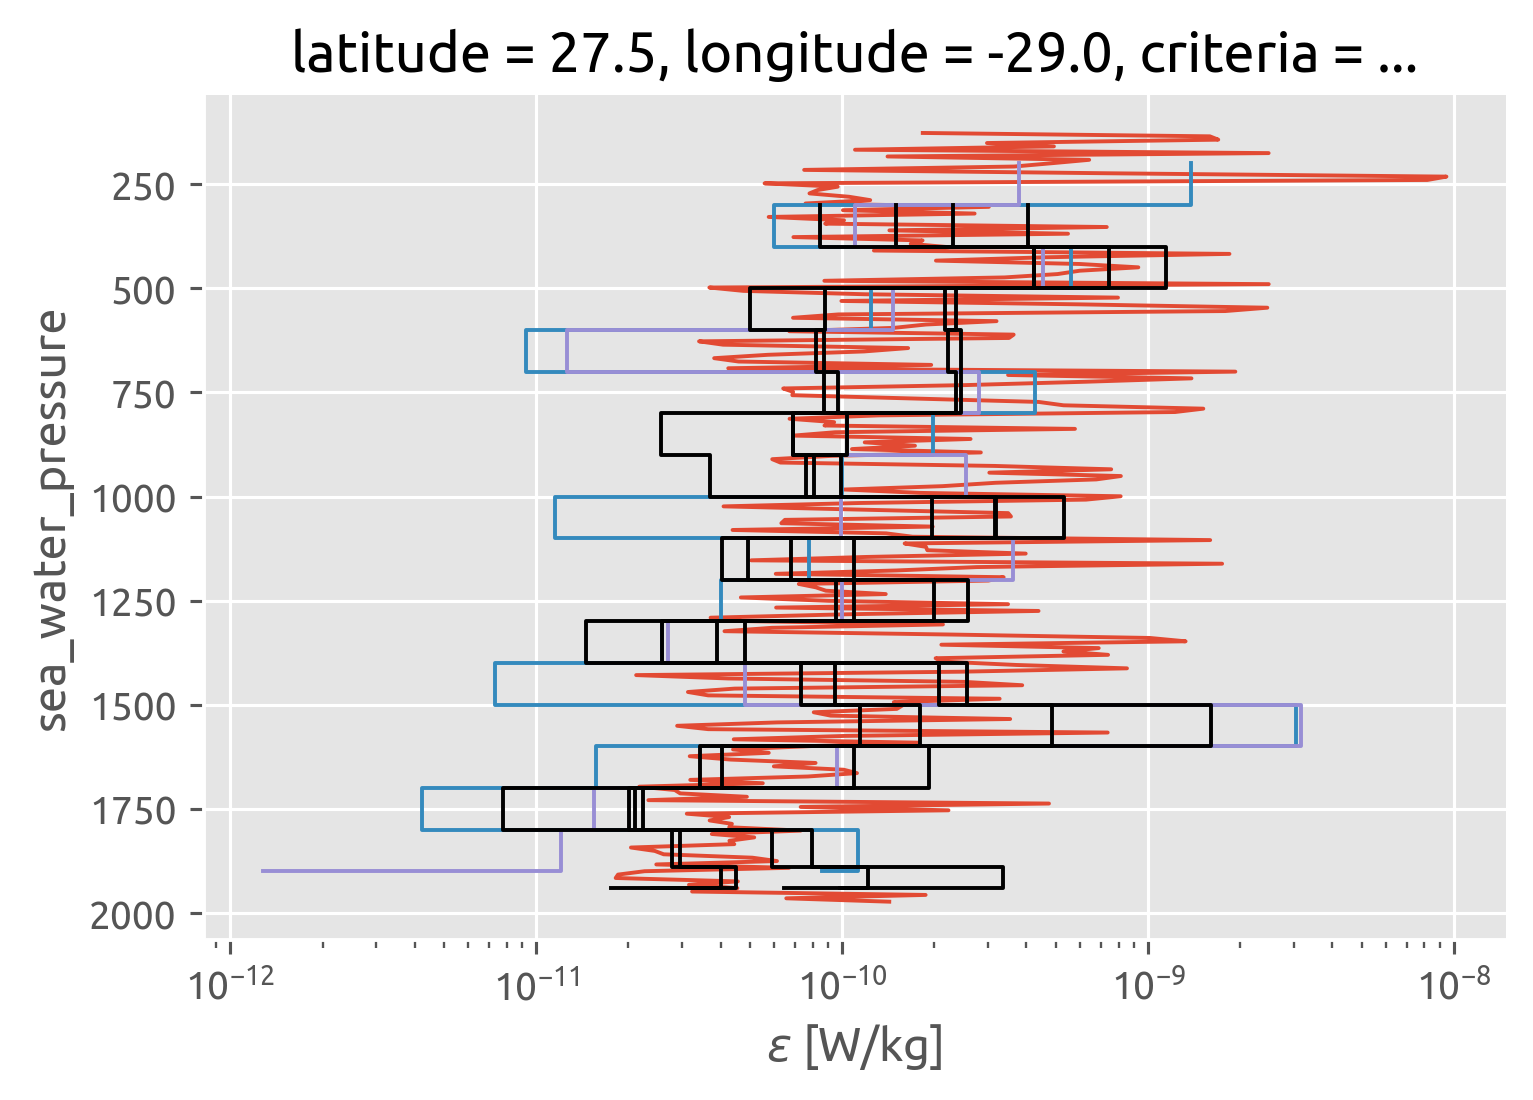

In [58]:
profile = fix_profile(stacked.isel(latlon=[40]))
ms = dcpy.finestructure.do_mixsea_shearstrain(profile, dz_segment=200)
dc = dcpy.finestructure.process_profile(profile, dz_segment=200, criteria=None)

profile.eps.coarsen(pres=20, boundary="trim").mean().plot(y="pres")
ms.eps.isel(kind=0).plot.step(y="depth_bin", xscale="log", yincrease=False)
ms.eps.isel(kind=1).plot.step(y="depth_bin", xscale="log", yincrease=False)
for crit in dc.criteria:
    dc.sel(criteria=crit).ε.cf.plot.step(color="k")

In [389]:
from dask.distributed import Client

client = Client("tcp://127.0.0.1:41667")
client

<Client: 'tcp://127.0.0.1:41667' processes=4 threads=8, memory=31.10 GiB>

In [59]:
computed = dask.compute(results, scheduler="threads")

/home/deepak/work/python/dcpy/dcpy/finestructure.py:311: RuntimeWarning: invalid value encountered in true_divide
  scale = (ξvar / ξgmvar) ** 2 * h_Rω * L_Nf
/home/deepak/work/python/dcpy/dcpy/finestructure.py:311: RuntimeWarning: invalid value encountered in true_divide
  scale = (ξvar / ξgmvar) ** 2 * h_Rω * L_Nf


In [60]:
def fix_result(profile):
    return (
        profile.rename_dims({"pressure": "pressure_"})
        .reset_coords()
        .set_coords(["latitude", "longitude"])
        .expand_dims(["latitude", "longitude"])
        .assign_coords({"pressure_": np.arange(profile.sizes["pressure"])})
    )


combined = xr.combine_by_coords([fix_result(ds) for ds in computed[0]])
combined = combined.cf.guess_coord_axis()

In [62]:
combined.to_netcdf("../datasets/natre-finescale.nc")

In [672]:
avg = combined.groupby_bins("pressure", np.arange(150, 2060, 100)).mean()

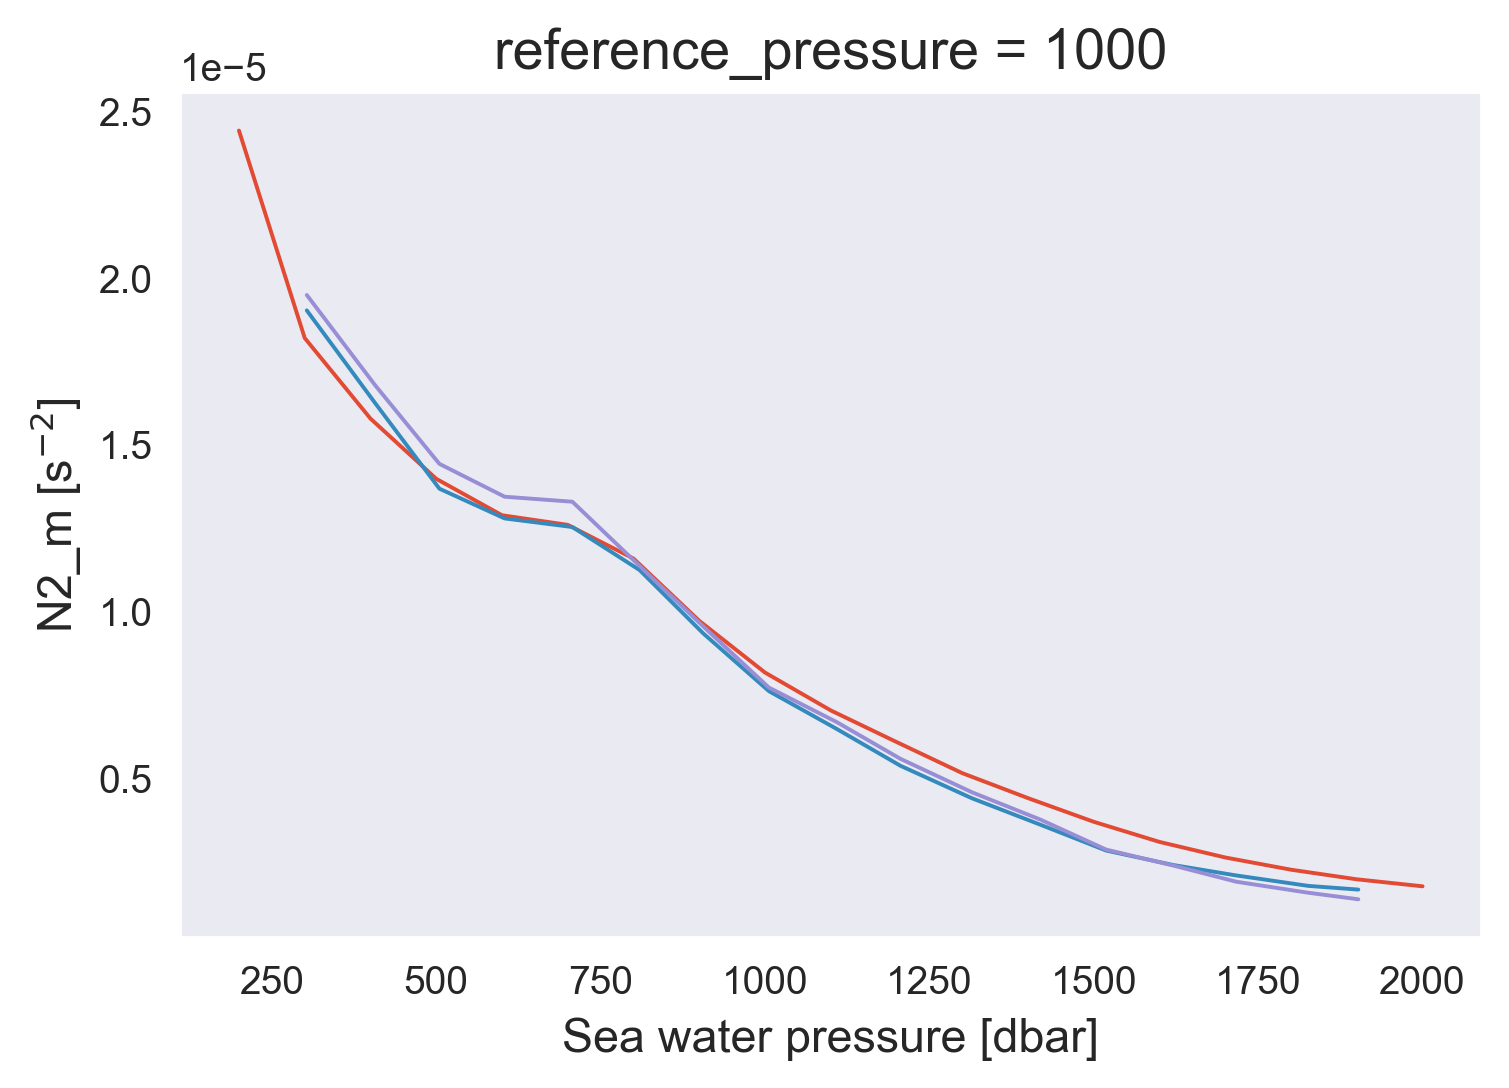

In [655]:
avg.N2mean.plot()
micro.N2.plot(x="pres")
micro.N2_m.plot(x="pres")

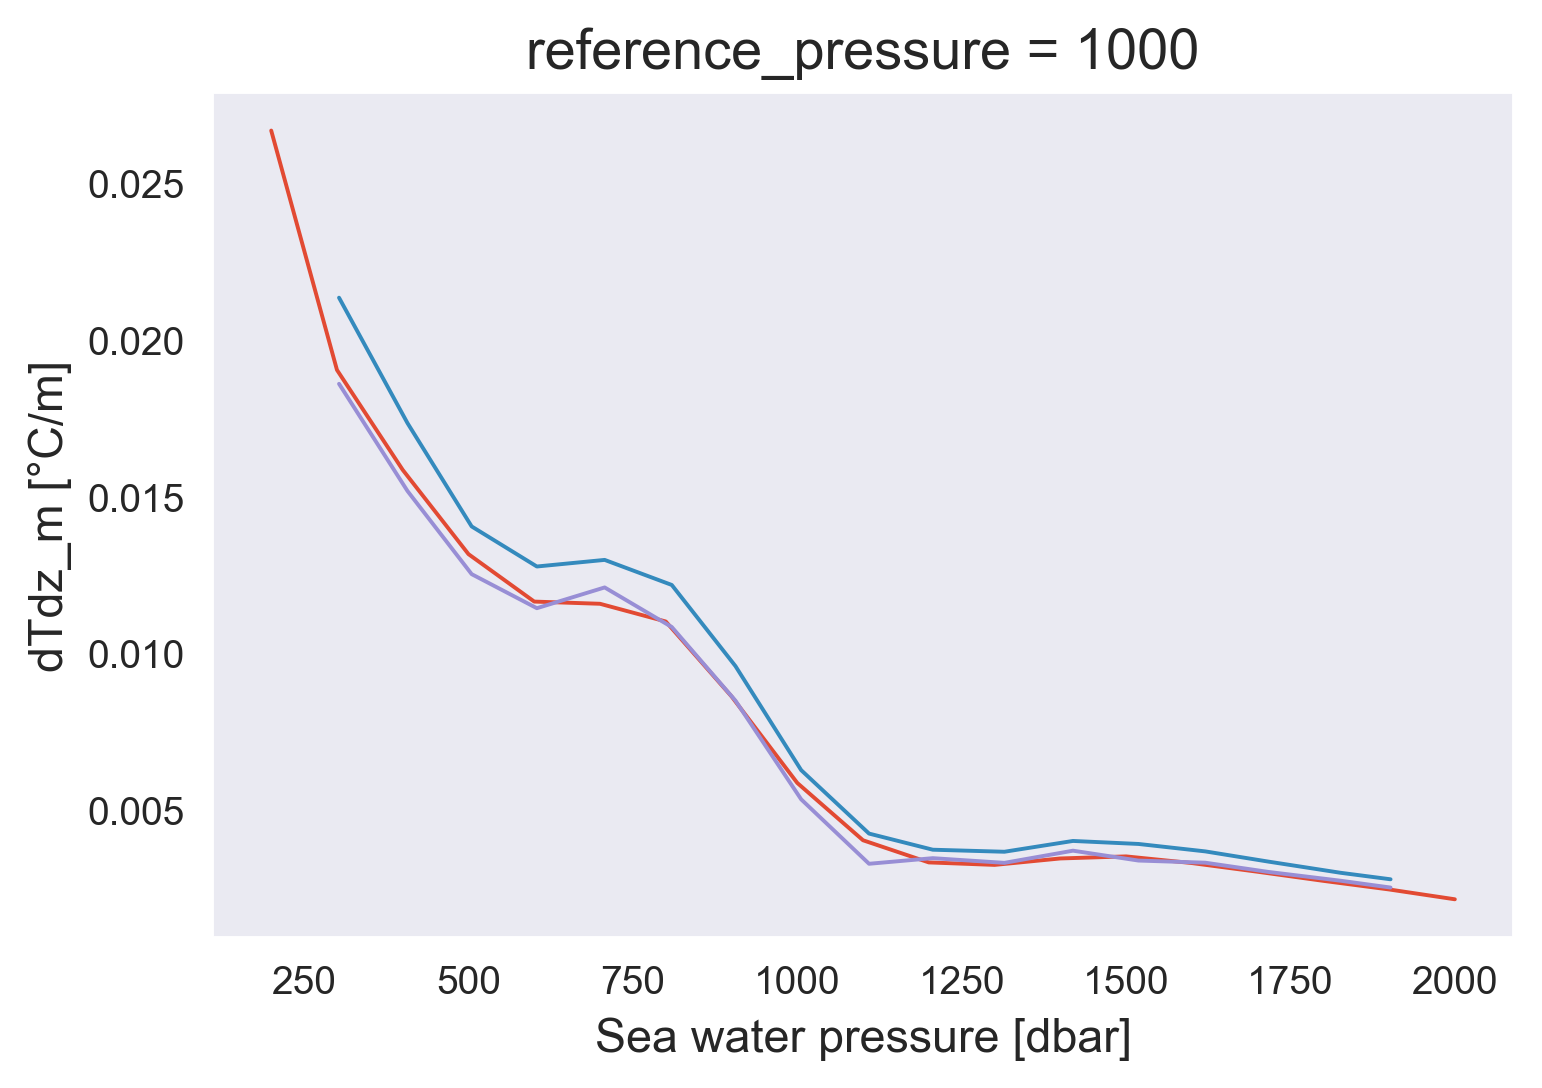

In [653]:
avg.Tzmean.plot()
micro.Tz.plot(x="pres")
micro.dTdz_m.plot(x="pres")

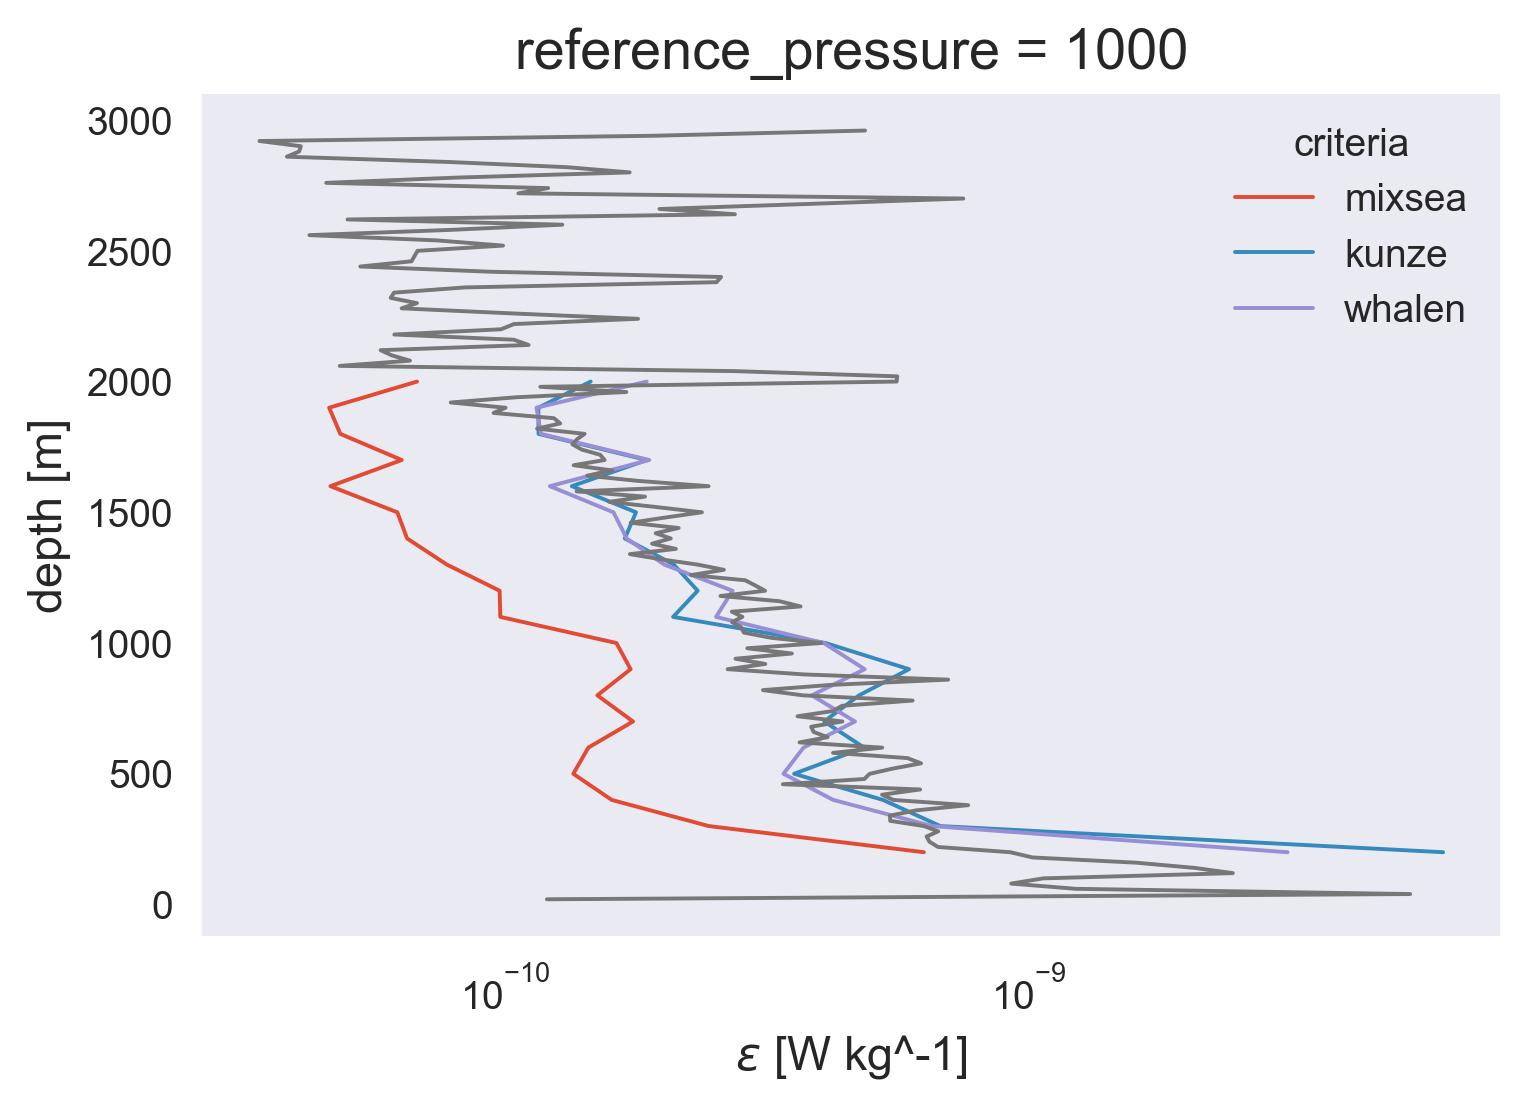

In [750]:
avg.ε.plot(y="pressure_bins", hue="criteria", xscale="log")
natre.eps.mean(["latitude", "longitude"]).coarsen(
    depth=50, boundary="trim"
).mean().plot(y="depth")

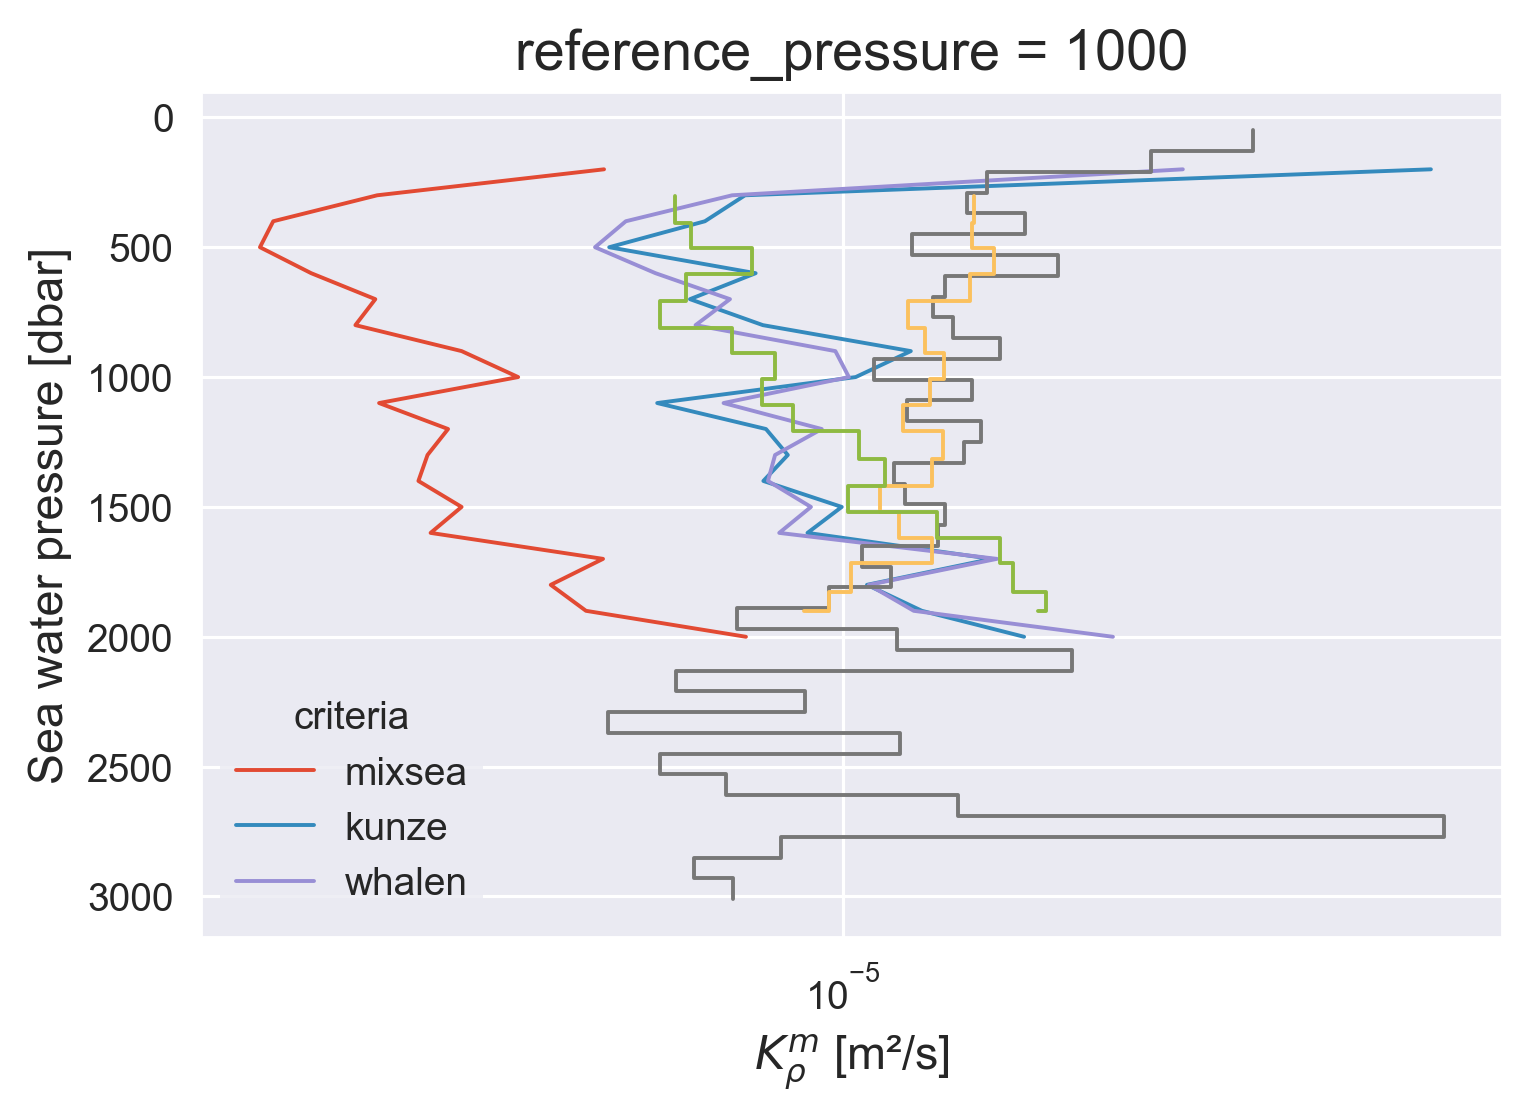

In [756]:
(avg.Kρ).plot(y="pressure_bins", hue="criteria", xscale="log")
natre.Krho.coarsen(depth=200, boundary="trim").mean().mean(
    ["latitude", "longitude"]
).plot.step(y="depth")
micro.Krho.plot.step(y="pres")
micro.Krho_m.plot.step(y="pres", yincrease=False)
plt.gca().grid(True)

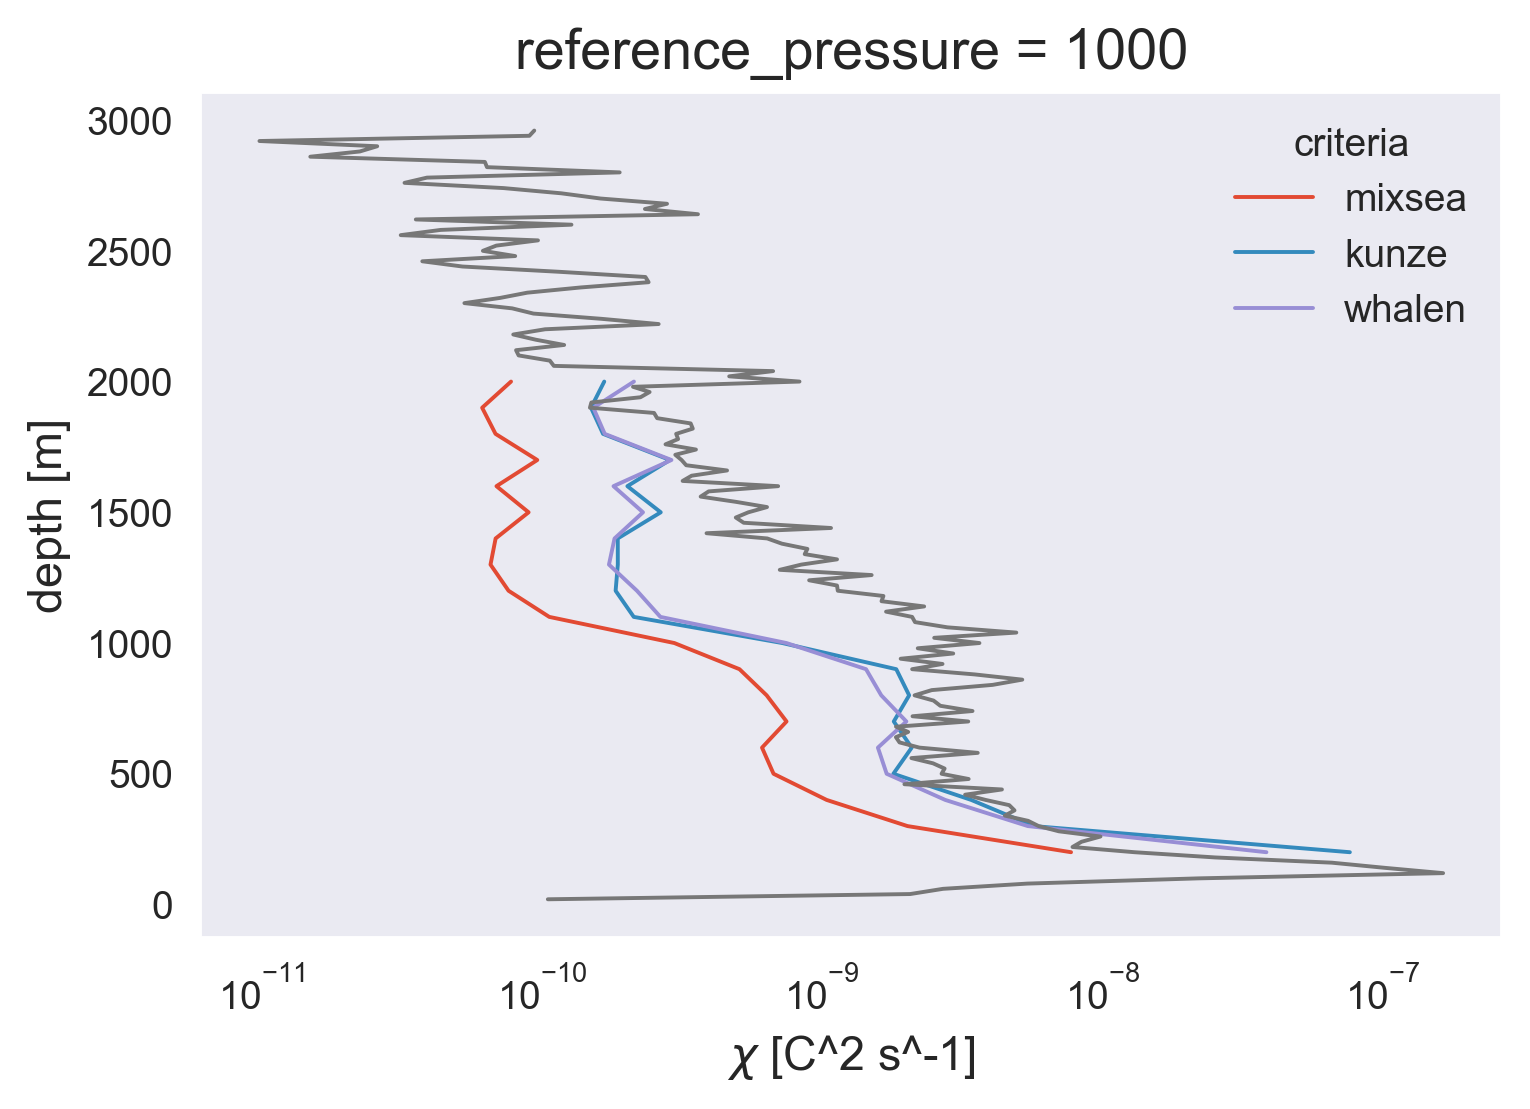

In [675]:
(avg.χ).plot(y="pressure_bins", hue="criteria", xscale="log")
natre.chi.mean(["latitude", "longitude"]).coarsen(
    depth=50, boundary="trim"
).mean().plot(y="depth")

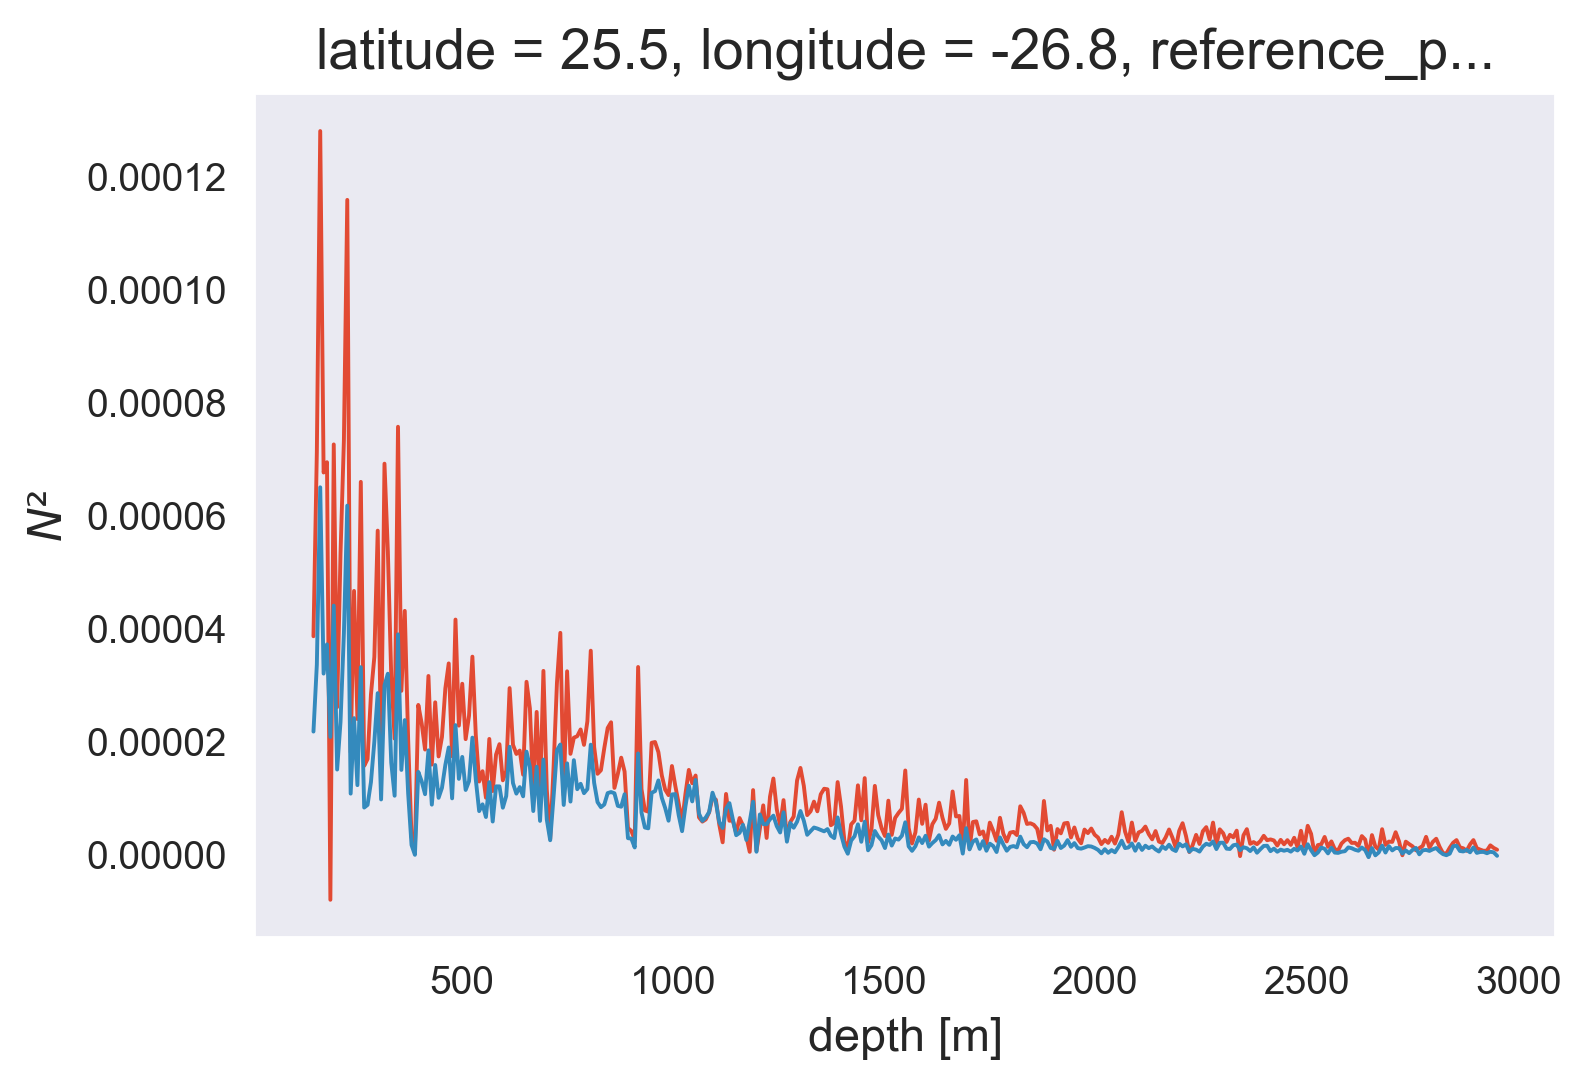

In [742]:
(9.81 * 1.7e-4 * profile.Tz).plot()
profile.N2.plot()

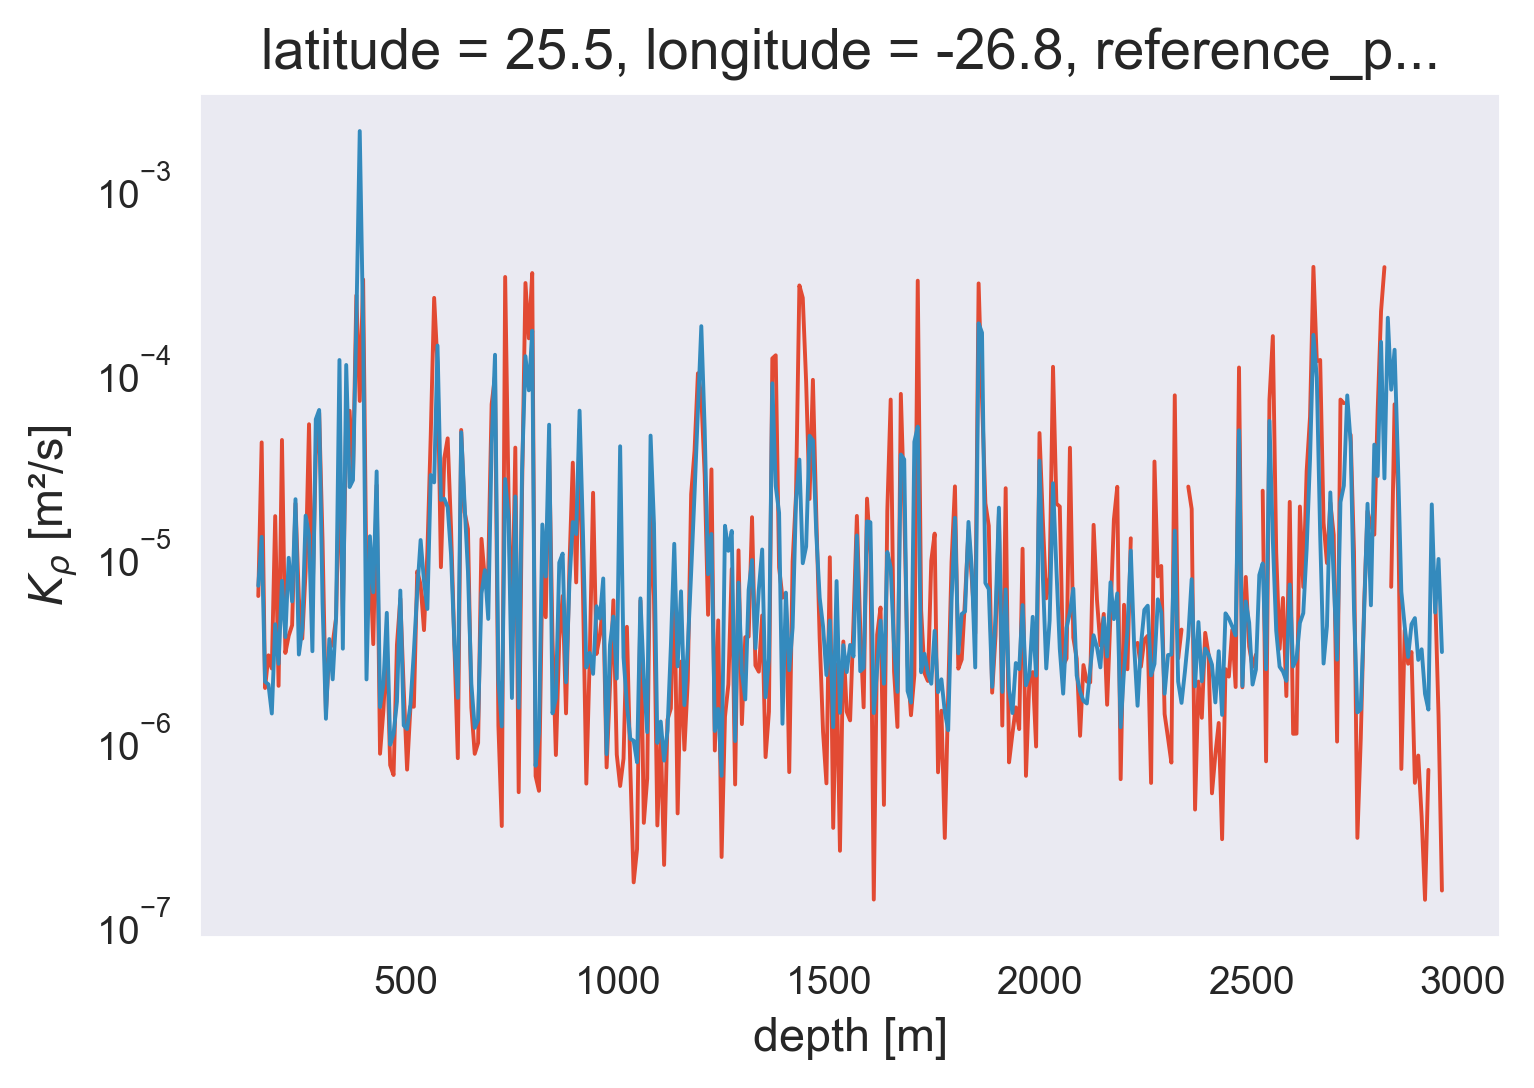

In [739]:
profile = natre.isel(latitude=5, longitude=9).coarsen(depth=20, boundary="trim").mean()

profile.Kt.plot()
profile.Krho.plot(yscale="log")